In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import math

import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from lion_pytorch import Lion

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from copy import deepcopy

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump
from joblib import load
import os

In [2]:
torch.cuda.is_available()

True

In [2]:
fstdr = pd.read_csv("fstdr_dataset.csv")
fstd = pd.read_csv("fstdr_dataset.csv")
stdr = pd.read_csv("fstdr_dataset.csv")
std = pd.read_csv("fstdr_dataset.csv")

# Training ML and MLP models

In [12]:
class MLP(nn.Module):
    def __init__(self, input: int = 10, output: int = 1, hidden: int = 5, shape: int | list[int] = 4096, activation: nn = None):
        super(MLP, self).__init__()
        self.input = input # Number of features
        self.output = output # Number of classes
        self.hidden = hidden # Number of hidden layers
        self.shape = shape # Number of neurons in each hidden layer
        self.activation = activation # Final Activation Function
        self.layers = self.make_layers() # automatically create the layers

    def make_layers(self):
        """
        Create the layers of the model
        """
        if isinstance(self.shape, list):
          if len(self.shape) != self.hidden:
            raise ValueError("The length of shape must be equal to hidden")
          aux = nn.Sequential(
            nn.Linear(self.input, self.shape[0]),
            nn.BatchNorm1d(self.shape[0]),
            nn.GELU()
          )
          layers = [aux]
          for i in range(1, self.hidden):
            aux = nn.Sequential(
              nn.Linear(self.shape[i-1], self.shape[i]),
              nn.BatchNorm1d(self.shape[i]),
              nn.GELU()
            )
            layers.append(aux)
          layers.append(nn.Linear(self.shape[-1], self.output))
        else:
          aux = nn.Sequential(
            nn.Linear(self.input, self.shape),
            nn.BatchNorm1d(self.shape),
            nn.GELU()
          )
          layers = [aux]
          for i in range(self.hidden-1):
            aux = nn.Sequential(
              nn.Linear(self.shape, self.shape),
              nn.BatchNorm1d(self.shape),
              nn.GELU()
            )
            layers.append(aux)
          layers.append(nn.Linear(self.shape, self.output))
        if self.activation is not None:
          layers.append(self.activation)
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Method to pass the input through the layers
        """
        for l in self.layers:
            x = l(x)
        return x



In [4]:
def to_GPU(model):
    num_gpus = torch.cuda.device_count()
    if num_gpus == 0:
        print("Nenhuma GPU disponível. Usando a CPU.")
        device = torch.device("cpu")
        model.to(device)
        return device

    print(f"GPUs disponíveis: {num_gpus}")

    for gpu_id in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(gpu_id)
        total_memory = torch.cuda.get_device_properties(gpu_id).total_memory / 1e9  # Em GB
        allocated_memory = torch.cuda.memory_reserved(gpu_id) / 1e9  # Em GB
        free_memory = total_memory - allocated_memory

        print(f"GPU {gpu_id} ({gpu_name}):")
        print(f"  Memória total: {total_memory:.2f} GB")
        print(f"  Memória alocada: {allocated_memory:.2f} GB")
        print(f"  Memória livre: {free_memory:.2f} GB")

        if free_memory >= 20.0:
            print(f"Usando GPU {gpu_id} ({gpu_name}) com {free_memory:.2f} GB de memória livre.")
            device = torch.device(f"cuda:{gpu_id}")
            model.to(device).float()  # Converter para meia precisão
            return device

In [5]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics for binary classification.
    Parameters:
    y_true (list or array-like): True binary labels.
    y_pred (list or array-like): Predicted scores or probabilities.
    Returns:
    dict: A dictionary containing the following metrics:
        - 'accuracy': Accuracy of the predictions, rounded to 4 decimal places.
        - 'precision': Precision of the predictions, rounded to 4 decimal places.
        - 'recall': Recall of the predictions, rounded to 4 decimal places.
        - 'f1_score': F1 score of the predictions, rounded to 4 decimal places.
    """
    aux = [1 if i > 0 else 0 for i in y_pred]
    accuracy = accuracy_score(y_true, aux)
    precision = precision_score(y_true, aux)
    recall = recall_score(y_true, aux)
    f1 = f1_score(y_true, aux)
    # desviacion estandard
    return {
        'accuracy': round(accuracy, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1, 4)
    }

In [6]:
class EarlyStopping:
    """
    Classe por evaluar el modelo y detener el entrenamiento si el desempeño no mejora
    por defecto el espera 10 epocas
    """
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.counter = 0
        self.best_metric = None
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, metric):
        if self.best_metric is None:
            self.best_metric = metric
        elif metric <= self.best_metric:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_metric = metric
            self.counter = 0

In [7]:
"""
funcion que guarda el modelo, utilizada principalmente para earling stopping
"""
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, path)

"""
funcion que carga el modelo. Utilizada para cojer el mejor modelo del entrenamiento
"""
def load_model(PATH, model):
    import io
    with open(PATH, 'rb') as f:
        buffer = io.BytesIO(f.read())
    device = to_GPU(model)
    checkpoint = torch.load(buffer, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [8]:
def selectOptimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == "Adam":
        optimizer = optim.Adam(
            params=model.parameters(),
            lr=lr,
            betas=(0.98, 0.92),
            eps=1e-8,
            weight_decay=weight_decay
        )
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(
            params=model.parameters(),
            lr=lr,
            betas=(0.98, 0.92),
            eps=1e-8,
            weight_decay=weight_decay
        )
    elif optimizer_name == "Lion":
        optimizer = Lion(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay
        )
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(
            params=model.parameters(),
            lr=lr,
            momentum=0.9,
            weight_decay=weight_decay
        )
    else:
        raise ValueError(f"Otimizador {optimizer_name} não reconhecido.")
    return optimizer

In [9]:
def predict(model, X, Y, batch_size=32):
    device = next(model.parameters()).device
    fn_loss = nn.BCEWithLogitsLoss(torch.tensor(274/226).to(device))
    X = torch.Tensor(X).float()
    Y = torch.tensor(Y, dtype=torch.uint8)
    loader = data.DataLoader(data.TensorDataset(X, Y), batch_size=batch_size, shuffle=False)
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = fn_loss(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            all_preds.append(outputs.detach().to("cpu").numpy())
            all_labels.extend(labels.detach().to("cpu").numpy())
            del inputs, labels, outputs
            torch.cuda.empty_cache()
    val_loss /= len(loader)
    all_preds = np.concatenate(all_preds, axis=0)
    val_metrics = calculate_metrics(all_labels, all_preds)
    del loader, all_labels
    torch.cuda.empty_cache()
    return {
        "predictions": all_preds,
        "loss": val_loss,
        "metrics": val_metrics
    }

In [10]:
def fit_and_evaluate(model, t_x, t_y, v_x, v_y, optimizer, EPOCHS=500, batch_size=8, name="", scheduler=None):
    device = next(model.parameters()).device
    fn_loss = nn.BCEWithLogitsLoss(torch.tensor(274/226).to(device))
    early_stopping = EarlyStopping(patience=25, verbose=True)
    best_model_path = f'./models_class/{name}.pth'
    train_loader = data.DataLoader(data.TensorDataset(t_x, t_y), batch_size=batch_size, shuffle=True)
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        all_train_labels = []
        all_train_outputs = []
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.to(device)
            loss = fn_loss(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            all_train_labels.extend(labels.detach().to("cpu").numpy())
            all_train_outputs.extend(outputs.detach().to("cpu").numpy())
            del inputs, labels, outputs
            torch.cuda.empty_cache()
        train_loss /= len(train_loader)
        train_metrics = calculate_metrics(all_train_labels, all_train_outputs)
        print(f"name: {name} | Epoch {epoch+1}/{EPOCHS}: \n"
              f"Train(loss: {train_loss:.4f}, Metrics: {train_metrics})")
        with torch.no_grad():
            metricas = predict(model, v_x, v_y, batch_size)
        print(f'Validacion(loss: {metricas["loss"]}, Metrics: {metricas["metrics"]}')
        early_stopping(metricas["metrics"]["accuracy"])
        if(math.isnan(train_loss)):
            break
        if early_stopping.counter == 0:
            save_model(model, best_model_path)
        if scheduler:
                scheduler.step(metrics=metricas["metrics"]["accuracy"])
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        print("-" * 126)
    del train_loader, all_train_labels, all_train_outputs, train_metrics, metricas
    del t_x, t_y, v_x, v_y
    torch.cuda.empty_cache()
    return early_stopping.best_metric

In [11]:
def train(model, X, Y, optimizer_name, epochs=500, batch_size=8, num_splits=5, name=""):
    model_copy = deepcopy(model)
    model_copy.float()
    best_metric = -1
    kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_recall = []
    fold_precision = []
    fold_f1 = []
    changed_gpu = True
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, Y)):
        print(f"\nTreinando Fold {fold + 1}")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = Y[train_idx], Y[val_idx]
        X_train = torch.Tensor(X_train).float()
        y_train = torch.tensor(y_train, dtype=torch.uint8)
        torch.cuda.empty_cache()
        while True:
            try:
                device = to_GPU(model_copy)
                break
            except RuntimeError as e:
                if 'out of memory' in str(e):
                   torch.cuda.empty_cache()
                   device = to_GPU(model_copy)
                else:
                    raise e
        while True:
            try:
                optimizer = selectOptimizer(model_copy, optimizer_name, 1e-4, 1e-3)
                scheduler = ReduceLROnPlateau(
                    optimizer=optimizer,     # Passa o otimizador
                    mode='max',         # Minimiza a métrica monitorada
                    factor=0.5,         # Reduz a lr pela metade
                    patience=5,         # Espera 5 épocas sem melhora antes de reduzir
                    verbose=True,       # Mostra logs
                    min_lr=1e-6         # Limite inferior para a lr
                )
                print(y_train.shape)
                metric = fit_and_evaluate(model_copy, X_train, y_train, X_val, y_val, optimizer, epochs, batch_size, name=name, scheduler=scheduler)
                break
            except RuntimeError as e: #sirve para reducir el batch_size, caso la memoria no alcansa
                if 'out of memory' in str(e) or 'CUBLAS_STATUS_ALLOC_FAILED' in str(e):
                    torch.cuda.empty_cache()
                    if changed_gpu:
                        print(f"Reducing batch size from {batch_size} to {batch_size // 2}")
                        batch_size = batch_size // 2
                        if batch_size == 0:
                            raise RuntimeError("Batch size reduced to 0. Cannot proceed further.")
                        changed_gpu = False
                    else:
                        device = to_GPU(model_copy)
                        changed_gpu = True
                else:
                    raise e
        del X_train, y_train
        torch.cuda.empty_cache()
        model_copy = load_model(f'./models_class/{name}.pth', model_copy)
        with torch.no_grad():
            metricas = predict(model_copy, X_val, y_val, batch_size)
        with open("results.txt", "a") as f: #guardo las prediciones y el true label para cada fold
            f.write("name: " + name + f"Fold {fold + 1}""\n")
            f.write("y_test: " + str(y_val) + "\n")
            f.write("y_pred: " + str(metricas["predictions"]) + "\n") # numeros + es para classe 1 y - classe 0
        del X_val, y_val
        torch.cuda.empty_cache()
        print(f"Metricas Validacion Fold {fold + 1}: ", metricas["metrics"])
        fold_accuracies.append(metricas["metrics"]["accuracy"])
        fold_recall.append(metricas["metrics"]["recall"])
        fold_precision.append(metricas["metrics"]["precision"])
        fold_f1.append(metricas["metrics"]["f1_score"])
        if(metric > best_metric):
            best_metric = metric
            save_model(model_copy, f'./models_class/{name}.pth')
        del model_copy, scheduler
        torch.cuda.empty_cache()
        model_copy = deepcopy(model).to(device).float()
        print("=" * 126)
    mean_accuracy = np.mean(fold_accuracies)
    mean_recall = np.mean(fold_recall)
    mean_precision = np.mean(fold_precision)
    mean_f1 = np.mean(fold_f1)
    std_accuracy = np.std(fold_accuracies)
    std_recall = np.std(fold_recall)
    std_precision = np.std(fold_precision)
    std_f1 = np.std(fold_f1)
    with open("results.txt", "a") as f: #guarda las metricas de validadcion para cada fold
            f.write("name: " + name +"\n")
            f.write(f"\nAcurácia Média: {mean_accuracy:.4f} ± {std_accuracy:.4f}" + "\n")
            f.write(f"\nRecall Média: {mean_recall:.4f} ± {std_recall:.4f}" + "\n")
            f.write(f"\nPrecicion Média: {mean_precision:.4f} ± {std_precision:.4f}" + "\n")
            f.write(f"\nF1 Média: {mean_f1:.4f} ± {std_f1:.4f}" + "\n")
    print(f"Acurácia Média: {mean_accuracy:.4f} ± {std_accuracy:.4f}"+
          f"\nPrecicion Média: {mean_precision:.4f} ± {std_precision:.4f}"+
          f"\nRecall Média: {mean_recall:.4f} ± {std_recall:.4f}"+
          f"\nF1 Média: {mean_f1:.4f} ± {std_f1:.4f}")
    model = load_model(f'./models_class/{name}.pth', model)
    model.to("cpu")
    del model_copy
    del X, Y
    torch.cuda.empty_cache()
    return model

In [12]:
def to_data_train(df):
  X = df.drop(columns=["class"]).values
  y = df["class"].values
  return X,y

In [13]:
X_fstdr, y_fstdr = to_data_train(fstdr)
X_stdr, y_stdr = to_data_train(stdr)
X_fstd, y_fstd = to_data_train(fstd)
X_std, y_std = to_data_train(std)

In [70]:
model_1_fstdr = MLP(shape=4096)
model_1_stdr = MLP(shape=4096)
model_1_fstd = MLP(shape=4096)
model_1_std = MLP(shape=4096)

model_2_fstdr = MLP(shape=[512,1024,2048,1024,512])
model_2_stdr = MLP(shape=[512,1024,2048,1024,512])
model_2_fstd = MLP(shape=[512,1024,2048,1024,512])
model_2_std = MLP(shape=[512,1024,2048,1024,512])

In [71]:
model_1_fstdr = train(model_1_fstdr, X_fstdr, y_fstdr,"Adam", name="model_1_fstdr",epochs=100,batch_size=400)
model_1_stdr = train(model_1_stdr, X_stdr, y_stdr, "Adam", name="model_1_stdr",epochs=100, batch_size=400)
model_1_fstd = train(model_1_fstd, X_fstd, y_fstd, "Adam", name="model_1_fstd",epochs=100, batch_size=400)
model_1_std = train(model_1_std, X_std, y_std, "Adam", name="model_1_std",epochs=100, batch_size=400)

model_2_fstdr = train(model_2_fstdr, X_fstdr, y_fstdr, "Adam", name="model_2_fstdr",epochs=100, batch_size=400)
model_2_stdr = train(model_2_stdr, X_stdr, y_stdr, "Adam", name="model_2_stdr",epochs=100, batch_size=400)
model_2_fstd = train(model_2_fstd, X_fstd, y_fstd, "Adam", name="model_2_fstd",epochs=100, batch_size=400)
model_2_std = train(model_2_std, X_std, y_std, "Adam", name="model_2_std",epochs=100, batch_size=400)


Treinando Fold 1
GPUs disponíveis: 1
GPU 0 (NVIDIA GeForce RTX 4050 Laptop GPU):
  Memória total: 6.08 GB
  Memória alocada: 0.00 GB
  Memória livre: 6.08 GB
torch.Size([400])


/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstdr | Epoch 1/100: 
Train(loss: 0.8740, Metrics: {'accuracy': 0.38, 'precision': 0.3731, 'recall': 0.5556, 'f1_score': 0.4464})
Validacion(loss: 0.6336499452590942, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 2/100: 
Train(loss: 0.2859, Metrics: {'accuracy': 0.9125, 'precision': 0.9191, 'recall': 0.8833, 'f1_score': 0.9008})
Validacion(loss: 0.5199899077415466, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 3/100: 
Train(loss: 0.2184, Metrics: {'accuracy': 0.925, 'precision': 0.9412, 'recall': 0.8889, 'f1_score': 0.9143})
Validacion(loss: 0.4290008842945099, Metrics: {'

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstdr | Epoch 1/100: 
Train(loss: 0.8780, Metrics: {'accuracy': 0.3875, 'precision': 0.3797, 'recall': 0.558, 'f1_score': 0.4519})
Validacion(loss: 0.6306557655334473, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 2/100: 
Train(loss: 0.2848, Metrics: {'accuracy': 0.9075, 'precision': 0.9091, 'recall': 0.884, 'f1_score': 0.8964})
Validacion(loss: 0.5171189904212952, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 3/100: 
Train(loss: 0.2155, Metrics: {'accuracy': 0.9275, 'precision': 0.9471, 'recall': 0.8895, 'f1_score': 0.9174})
Validacion(loss: 0.425162672996521, Metrics: {'

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstdr | Epoch 1/100: 
Train(loss: 0.8802, Metrics: {'accuracy': 0.36, 'precision': 0.3616, 'recall': 0.5414, 'f1_score': 0.4336})
Validacion(loss: 0.641683042049408, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 2/100: 
Train(loss: 0.2866, Metrics: {'accuracy': 0.9075, 'precision': 0.9138, 'recall': 0.8785, 'f1_score': 0.8958})
Validacion(loss: 0.5341082215309143, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 3/100: 
Train(loss: 0.2219, Metrics: {'accuracy': 0.9225, 'precision': 0.936, 'recall': 0.8895, 'f1_score': 0.9122})
Validacion(loss: 0.44364407658576965, Metrics: {'

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstdr | Epoch 1/100: 
Train(loss: 0.8796, Metrics: {'accuracy': 0.3575, 'precision': 0.3538, 'recall': 0.5083, 'f1_score': 0.4172})
Validacion(loss: 0.6396341919898987, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 2/100: 
Train(loss: 0.2855, Metrics: {'accuracy': 0.9125, 'precision': 0.9195, 'recall': 0.884, 'f1_score': 0.9014})
Validacion(loss: 0.5288621187210083, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 3/100: 
Train(loss: 0.2146, Metrics: {'accuracy': 0.9275, 'precision': 0.9471, 'recall': 0.8895, 'f1_score': 0.9174})
Validacion(loss: 0.4394841492176056, Metrics: 

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstdr | Epoch 1/100: 
Train(loss: 0.9160, Metrics: {'accuracy': 0.2975, 'precision': 0.3106, 'recall': 0.453, 'f1_score': 0.3685})
Validacion(loss: 0.8150694966316223, Metrics: {'accuracy': 0.61, 'precision': 0.5789, 'recall': 0.4889, 'f1_score': 0.5301}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 2/100: 
Train(loss: 0.0043, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8004006743431091, Metrics: {'accuracy': 0.64, 'precision': 0.6364, 'recall': 0.4667, 'f1_score': 0.5385}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstdr | Epoch 3/100: 
Train(loss: 0.0023, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.7908502221107483, Metrics: {'accuracy': 0.62, 'precision': 0.6129,

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_stdr | Epoch 1/100: 
Train(loss: 1.0025, Metrics: {'accuracy': 0.29, 'precision': 0.1829, 'recall': 0.1667, 'f1_score': 0.1744})
Validacion(loss: 0.6402577757835388, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 2/100: 
Train(loss: 0.2913, Metrics: {'accuracy': 0.915, 'precision': 0.9195, 'recall': 0.8889, 'f1_score': 0.904})
Validacion(loss: 0.5319411754608154, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 3/100: 
Train(loss: 0.2160, Metrics: {'accuracy': 0.9225, 'precision': 0.9357, 'recall': 0.8889, 'f1_score': 0.9117})
Validacion(loss: 0.4463087022304535, Metrics: {'accu

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_stdr | Epoch 1/100: 
Train(loss: 1.0029, Metrics: {'accuracy': 0.2825, 'precision': 0.1646, 'recall': 0.1436, 'f1_score': 0.1534})
Validacion(loss: 0.6369202136993408, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 2/100: 
Train(loss: 0.2926, Metrics: {'accuracy': 0.91, 'precision': 0.9096, 'recall': 0.8895, 'f1_score': 0.8994})
Validacion(loss: 0.5273022651672363, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 3/100: 
Train(loss: 0.2154, Metrics: {'accuracy': 0.93, 'precision': 0.9527, 'recall': 0.8895, 'f1_score': 0.92})
Validacion(loss: 0.4391636252403259, Metrics: {'accura

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_stdr | Epoch 1/100: 
Train(loss: 1.0075, Metrics: {'accuracy': 0.28, 'precision': 0.1977, 'recall': 0.1934, 'f1_score': 0.1955})
Validacion(loss: 0.650336742401123, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 2/100: 
Train(loss: 0.2910, Metrics: {'accuracy': 0.9125, 'precision': 0.9195, 'recall': 0.884, 'f1_score': 0.9014})
Validacion(loss: 0.5483245849609375, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 3/100: 
Train(loss: 0.2169, Metrics: {'accuracy': 0.9275, 'precision': 0.9471, 'recall': 0.8895, 'f1_score': 0.9174})
Validacion(loss: 0.4645152986049652, Metrics: {'accu

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_stdr | Epoch 1/100: 
Train(loss: 1.0148, Metrics: {'accuracy': 0.2875, 'precision': 0.1829, 'recall': 0.1657, 'f1_score': 0.1739})
Validacion(loss: 0.6464931964874268, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 2/100: 
Train(loss: 0.2884, Metrics: {'accuracy': 0.91, 'precision': 0.9096, 'recall': 0.8895, 'f1_score': 0.8994})
Validacion(loss: 0.5412158370018005, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 3/100: 
Train(loss: 0.2132, Metrics: {'accuracy': 0.93, 'precision': 0.9581, 'recall': 0.884, 'f1_score': 0.9195})
Validacion(loss: 0.4563603699207306, Metrics: {'accur

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_stdr | Epoch 1/100: 
Train(loss: 1.0041, Metrics: {'accuracy': 0.2975, 'precision': 0.1875, 'recall': 0.1657, 'f1_score': 0.176})
Validacion(loss: 0.8164265155792236, Metrics: {'accuracy': 0.61, 'precision': 0.5789, 'recall': 0.4889, 'f1_score': 0.5301}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 2/100: 
Train(loss: 0.0056, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8018548488616943, Metrics: {'accuracy': 0.64, 'precision': 0.6364, 'recall': 0.4667, 'f1_score': 0.5385}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_stdr | Epoch 3/100: 
Train(loss: 0.0023, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.7925567030906677, Metrics: {'accuracy': 0.63, 'precision': 0.6333, 'r

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstd | Epoch 1/100: 
Train(loss: 0.8276, Metrics: {'accuracy': 0.6175, 'precision': 0.5799, 'recall': 0.5444, 'f1_score': 0.5616})
Validacion(loss: 0.6318427920341492, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 2/100: 
Train(loss: 0.2857, Metrics: {'accuracy': 0.9125, 'precision': 0.9191, 'recall': 0.8833, 'f1_score': 0.9008})
Validacion(loss: 0.5225217342376709, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 3/100: 
Train(loss: 0.2800, Metrics: {'accuracy': 0.9125, 'precision': 0.9096, 'recall': 0.8944, 'f1_score': 0.902})
Validacion(loss: 0.42598941922187805, Metrics: {'

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstd | Epoch 1/100: 
Train(loss: 0.8304, Metrics: {'accuracy': 0.585, 'precision': 0.5472, 'recall': 0.4807, 'f1_score': 0.5118})
Validacion(loss: 0.6299147605895996, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 2/100: 
Train(loss: 0.2935, Metrics: {'accuracy': 0.9125, 'precision': 0.9195, 'recall': 0.884, 'f1_score': 0.9014})
Validacion(loss: 0.5220804810523987, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 3/100: 
Train(loss: 0.2906, Metrics: {'accuracy': 0.915, 'precision': 0.9153, 'recall': 0.895, 'f1_score': 0.905})
Validacion(loss: 0.42450594902038574, Metrics: {'accu

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstd | Epoch 1/100: 
Train(loss: 0.8258, Metrics: {'accuracy': 0.59, 'precision': 0.5509, 'recall': 0.5083, 'f1_score': 0.5287})
Validacion(loss: 0.6392964720726013, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 2/100: 
Train(loss: 0.2887, Metrics: {'accuracy': 0.9125, 'precision': 0.9195, 'recall': 0.884, 'f1_score': 0.9014})
Validacion(loss: 0.5379001498222351, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 3/100: 
Train(loss: 0.2838, Metrics: {'accuracy': 0.9175, 'precision': 0.9205, 'recall': 0.895, 'f1_score': 0.9076})
Validacion(loss: 0.4431301951408386, Metrics: {'accu

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstd | Epoch 1/100: 
Train(loss: 0.8290, Metrics: {'accuracy': 0.5925, 'precision': 0.5556, 'recall': 0.4972, 'f1_score': 0.5248})
Validacion(loss: 0.6387766599655151, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 2/100: 
Train(loss: 0.2849, Metrics: {'accuracy': 0.9125, 'precision': 0.9195, 'recall': 0.884, 'f1_score': 0.9014})
Validacion(loss: 0.5345790386199951, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 3/100: 
Train(loss: 0.2824, Metrics: {'accuracy': 0.915, 'precision': 0.92, 'recall': 0.8895, 'f1_score': 0.9045})
Validacion(loss: 0.44085487723350525, Metrics: {'acc

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_fstd | Epoch 1/100: 
Train(loss: 0.8235, Metrics: {'accuracy': 0.6225, 'precision': 0.5949, 'recall': 0.5193, 'f1_score': 0.5546})
Validacion(loss: 0.8153344988822937, Metrics: {'accuracy': 0.62, 'precision': 0.5946, 'recall': 0.4889, 'f1_score': 0.5366}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 2/100: 
Train(loss: 0.0041, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8018221855163574, Metrics: {'accuracy': 0.64, 'precision': 0.6364, 'recall': 0.4667, 'f1_score': 0.5385}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_fstd | Epoch 3/100: 
Train(loss: 0.0017, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.7928918600082397, Metrics: {'accuracy': 0.63, 'precision': 0.625, 'r

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_std | Epoch 1/100: 
Train(loss: 0.8168, Metrics: {'accuracy': 0.5425, 'precision': 0.493, 'recall': 0.5889, 'f1_score': 0.5367})
Validacion(loss: 0.6232330799102783, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 2/100: 
Train(loss: 0.2666, Metrics: {'accuracy': 0.915, 'precision': 0.9294, 'recall': 0.8778, 'f1_score': 0.9029})
Validacion(loss: 0.5125607848167419, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 3/100: 
Train(loss: 0.2097, Metrics: {'accuracy': 0.92, 'precision': 0.9302, 'recall': 0.8889, 'f1_score': 0.9091})
Validacion(loss: 0.42510873079299927, Metrics: {'accura

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_std | Epoch 1/100: 
Train(loss: 0.8159, Metrics: {'accuracy': 0.56, 'precision': 0.5117, 'recall': 0.6022, 'f1_score': 0.5533})
Validacion(loss: 0.6201260089874268, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 2/100: 
Train(loss: 0.2649, Metrics: {'accuracy': 0.9175, 'precision': 0.9302, 'recall': 0.884, 'f1_score': 0.9065})
Validacion(loss: 0.5092162489891052, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 3/100: 
Train(loss: 0.2062, Metrics: {'accuracy': 0.9275, 'precision': 0.9419, 'recall': 0.895, 'f1_score': 0.9178})
Validacion(loss: 0.42129021883010864, Metrics: {'accura

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_std | Epoch 1/100: 
Train(loss: 0.8136, Metrics: {'accuracy': 0.565, 'precision': 0.5166, 'recall': 0.6022, 'f1_score': 0.5561})
Validacion(loss: 0.6305914521217346, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 2/100: 
Train(loss: 0.2672, Metrics: {'accuracy': 0.915, 'precision': 0.9298, 'recall': 0.8785, 'f1_score': 0.9034})
Validacion(loss: 0.5247116088867188, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 3/100: 
Train(loss: 0.2089, Metrics: {'accuracy': 0.925, 'precision': 0.9364, 'recall': 0.895, 'f1_score': 0.9153})
Validacion(loss: 0.43727147579193115, Metrics: {'accura

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_std | Epoch 1/100: 
Train(loss: 0.8123, Metrics: {'accuracy': 0.5625, 'precision': 0.5138, 'recall': 0.6188, 'f1_score': 0.5614})
Validacion(loss: 0.6307078003883362, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 2/100: 
Train(loss: 0.2642, Metrics: {'accuracy': 0.915, 'precision': 0.9298, 'recall': 0.8785, 'f1_score': 0.9034})
Validacion(loss: 0.5236667394638062, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 3/100: 
Train(loss: 0.2051, Metrics: {'accuracy': 0.9325, 'precision': 0.9477, 'recall': 0.9006, 'f1_score': 0.9235})
Validacion(loss: 0.44025883078575134, Metrics: {'acc

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_1_std | Epoch 1/100: 
Train(loss: 0.7779, Metrics: {'accuracy': 0.6275, 'precision': 0.5708, 'recall': 0.7127, 'f1_score': 0.6339})
Validacion(loss: 0.8152585029602051, Metrics: {'accuracy': 0.61, 'precision': 0.5789, 'recall': 0.4889, 'f1_score': 0.5301}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 2/100: 
Train(loss: 0.0034, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8013878464698792, Metrics: {'accuracy': 0.62, 'precision': 0.5946, 'recall': 0.4889, 'f1_score': 0.5366}
------------------------------------------------------------------------------------------------------------------------------
name: model_1_std | Epoch 3/100: 
Train(loss: 0.0014, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.792832612991333, Metrics: {'accuracy': 0.63, 'precision': 0.625, 'recal

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstdr | Epoch 2/100: 
Train(loss: 0.3172, Metrics: {'accuracy': 0.92, 'precision': 0.9205, 'recall': 0.9, 'f1_score': 0.9101})
Validacion(loss: 0.7733402252197266, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 3/100: 
Train(loss: 0.2379, Metrics: {'accuracy': 0.9275, 'precision': 0.9364, 'recall': 0.9, 'f1_score': 0.9178})
Validacion(loss: 0.7437382340431213, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 4/100: 
Train(loss: 0.2131, Metrics: {'accuracy': 0.9275, 'precision': 0.9415, 'recall': 0.8944, 'f1_score': 0.9174})
Validacion(loss: 0

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstdr | Epoch 1/100: 
Train(loss: 0.8408, Metrics: {'accuracy': 0.475, 'precision': 0.4582, 'recall': 0.8785, 'f1_score': 0.6023})
Validacion(loss: 0.7999005317687988, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 2/100: 
Train(loss: 0.3168, Metrics: {'accuracy': 0.9175, 'precision': 0.9157, 'recall': 0.9006, 'f1_score': 0.9081})
Validacion(loss: 0.7720089554786682, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 3/100: 
Train(loss: 0.2371, Metrics: {'accuracy': 0.9275, 'precision': 0.9318, 'recall': 0.9061, 'f1_score': 0.9188})
Validacion(loss: 0.7421752214431763, Metrics: 

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstdr | Epoch 2/100: 
Train(loss: 0.3184, Metrics: {'accuracy': 0.925, 'precision': 0.9218, 'recall': 0.9116, 'f1_score': 0.9167})
Validacion(loss: 0.7759690880775452, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 3/100: 
Train(loss: 0.2382, Metrics: {'accuracy': 0.9275, 'precision': 0.9368, 'recall': 0.9006, 'f1_score': 0.9183})
Validacion(loss: 0.747721791267395, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 4/100: 
Train(loss: 0.2133, Metrics: {'accuracy': 0.9275, 'precision': 0.9419, 'recall': 0.895, 'f1_score': 0.9178})
Validacion(lo

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstdr | Epoch 2/100: 
Train(loss: 0.3133, Metrics: {'accuracy': 0.9225, 'precision': 0.9213, 'recall': 0.9061, 'f1_score': 0.9136})
Validacion(loss: 0.7752893567085266, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 3/100: 
Train(loss: 0.2348, Metrics: {'accuracy': 0.93, 'precision': 0.9371, 'recall': 0.9061, 'f1_score': 0.9213})
Validacion(loss: 0.7468785047531128, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 4/100: 
Train(loss: 0.2106, Metrics: {'accuracy': 0.9275, 'precision': 0.9419, 'recall': 0.895, 'f1_score': 0.9178})
Validacion(lo

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstdr | Epoch 2/100: 
Train(loss: 0.1971, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8306962847709656, Metrics: {'accuracy': 0.62, 'precision': 0.6522, 'recall': 0.3333, 'f1_score': 0.4412}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 3/100: 
Train(loss: 0.0892, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8270405530929565, Metrics: {'accuracy': 0.62, 'precision': 0.6207, 'recall': 0.4, 'f1_score': 0.4865}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstdr | Epoch 4/100: 
Train(loss: 0.0543, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8227607607

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_stdr | Epoch 2/100: 
Train(loss: 0.3124, Metrics: {'accuracy': 0.9175, 'precision': 0.9349, 'recall': 0.8778, 'f1_score': 0.9054})
Validacion(loss: 0.7723206877708435, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 3/100: 
Train(loss: 0.2367, Metrics: {'accuracy': 0.9225, 'precision': 0.9408, 'recall': 0.8833, 'f1_score': 0.9112})
Validacion(loss: 0.7423803806304932, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 4/100: 
Train(loss: 0.2137, Metrics: {'accuracy': 0.925, 'precision': 0.9412, 'recall': 0.8889, 'f1_score': 0.9143})
Validacion(los

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_stdr | Epoch 2/100: 
Train(loss: 0.3122, Metrics: {'accuracy': 0.9175, 'precision': 0.9353, 'recall': 0.8785, 'f1_score': 0.906})
Validacion(loss: 0.7724611163139343, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 3/100: 
Train(loss: 0.2357, Metrics: {'accuracy': 0.9225, 'precision': 0.9412, 'recall': 0.884, 'f1_score': 0.9117})
Validacion(loss: 0.742363691329956, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 4/100: 
Train(loss: 0.2121, Metrics: {'accuracy': 0.9275, 'precision': 0.9419, 'recall': 0.895, 'f1_score': 0.9178})
Validacion(loss: 

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_stdr | Epoch 2/100: 
Train(loss: 0.3157, Metrics: {'accuracy': 0.9175, 'precision': 0.9353, 'recall': 0.8785, 'f1_score': 0.906})
Validacion(loss: 0.7760878205299377, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 3/100: 
Train(loss: 0.2385, Metrics: {'accuracy': 0.925, 'precision': 0.9415, 'recall': 0.8895, 'f1_score': 0.9148})
Validacion(loss: 0.7475227117538452, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 4/100: 
Train(loss: 0.2149, Metrics: {'accuracy': 0.9275, 'precision': 0.9419, 'recall': 0.895, 'f1_score': 0.9178})
Validacion(loss:

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_stdr | Epoch 1/100: 
Train(loss: 0.8704, Metrics: {'accuracy': 0.415, 'precision': 0.3944, 'recall': 0.547, 'f1_score': 0.4583})
Validacion(loss: 0.8018252849578857, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 2/100: 
Train(loss: 0.3121, Metrics: {'accuracy': 0.9175, 'precision': 0.9405, 'recall': 0.8729, 'f1_score': 0.9054})
Validacion(loss: 0.7752977013587952, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 3/100: 
Train(loss: 0.2358, Metrics: {'accuracy': 0.925, 'precision': 0.9415, 'recall': 0.8895, 'f1_score': 0.9148})
Validacion(loss: 0.7465174794197083, Metrics: {'acc

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validacion(loss: 0.834368109703064, Metrics: {'accuracy': 0.61, 'precision': 0.625, 'recall': 0.3333, 'f1_score': 0.4348}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 2/100: 
Train(loss: 0.1935, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8305767774581909, Metrics: {'accuracy': 0.61, 'precision': 0.6071, 'recall': 0.3778, 'f1_score': 0.4658}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_stdr | Epoch 3/100: 
Train(loss: 0.0856, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8262766003608704, Metrics: {'accuracy': 0.61, 'precision': 0.6071, 'recall': 0.3778, 'f1_score': 0.4658}
EarlyStopping counter: 2 out of 25
----------------------------------------

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstd | Epoch 3/100: 
Train(loss: 0.2472, Metrics: {'accuracy': 0.9275, 'precision': 0.9314, 'recall': 0.9056, 'f1_score': 0.9183})
Validacion(loss: 0.7610219717025757, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 4/100: 
Train(loss: 0.2190, Metrics: {'accuracy': 0.9275, 'precision': 0.9415, 'recall': 0.8944, 'f1_score': 0.9174})
Validacion(loss: 0.7297801971435547, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 3 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 5/100: 
Train(loss: 0.2052, Metrics: {'accuracy': 0.93, 'precision': 0.9471, 'recall': 0.8944, 'f1_score': 0.92})
Validacion(loss: 

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 3/100: 
Train(loss: 0.2464, Metrics: {'accuracy': 0.93, 'precision': 0.9322, 'recall': 0.9116, 'f1_score': 0.9218})
Validacion(loss: 0.7601054906845093, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 4/100: 
Train(loss: 0.2174, Metrics: {'accuracy': 0.93, 'precision': 0.9422, 'recall': 0.9006, 'f1_score': 0.9209})
Validacion(loss: 0.7284219264984131, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 5/100: 


/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstd | Epoch 1/100: 
Train(loss: 0.8481, Metrics: {'accuracy': 0.52, 'precision': 0.4824, 'recall': 0.8343, 'f1_score': 0.6113})
Validacion(loss: 0.8154051303863525, Metrics: {'accuracy': 0.97, 'precision': 0.9375, 'recall': 1.0, 'f1_score': 0.9677}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 2/100: 
Train(loss: 0.3339, Metrics: {'accuracy': 0.9175, 'precision': 0.9157, 'recall': 0.9006, 'f1_score': 0.9081})
Validacion(loss: 0.791145384311676, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 3/100: 
Train(loss: 0.2472, Metrics: {'accuracy': 0.93, 'precision': 0.9371, 'recall': 0.9061, 'f1_score': 0.9213})
Validacion(loss: 0.7645764946937561, Metrics: {'accuracy': 1.0, 'precision': 1.0,

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_fstd | Epoch 2/100: 
Train(loss: 0.3334, Metrics: {'accuracy': 0.925, 'precision': 0.9266, 'recall': 0.9061, 'f1_score': 0.9162})
Validacion(loss: 0.7907487750053406, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 3/100: 
Train(loss: 0.2463, Metrics: {'accuracy': 0.93, 'precision': 0.9371, 'recall': 0.9061, 'f1_score': 0.9213})
Validacion(loss: 0.7642414569854736, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 4/100: 
Train(loss: 0.2176, Metrics: {'accuracy': 0.93, 'precision': 0.9422, 'recall': 0.9006, 'f1_score': 0.9209})
Validacion(loss: 0.7338881492614746, Metrics: {'accur

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 3/100: 
Train(loss: 0.0996, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8318636417388916, Metrics: {'accuracy': 0.59, 'precision': 0.5435, 'recall': 0.5556, 'f1_score': 0.5495}
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 4/100: 
Train(loss: 0.0631, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8276702165603638, Metrics: {'accuracy': 0.59, 'precision': 0.5476, 'recall': 0.5111, 'f1_score': 0.5287}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_fstd | Epoch 5/100: 
Train(loss: 0.0462, Metrics: {'accu

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Validacion(loss: 0.7742085456848145, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 3/100: 
Train(loss: 0.2331, Metrics: {'accuracy': 0.925, 'precision': 0.931, 'recall': 0.9, 'f1_score': 0.9153})
Validacion(loss: 0.7431014776229858, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 4/100: 
Train(loss: 0.2111, Metrics: {'accuracy': 0.9275, 'precision': 0.9314, 'recall': 0.9056, 'f1_score': 0.9183})
Validacion(loss: 0.708522617816925, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 3 out of 25
-----------------

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_std | Epoch 2/100: 
Train(loss: 0.3034, Metrics: {'accuracy': 0.9225, 'precision': 0.931, 'recall': 0.895, 'f1_score': 0.9127})
Validacion(loss: 0.7735298871994019, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 3/100: 
Train(loss: 0.2329, Metrics: {'accuracy': 0.9275, 'precision': 0.9318, 'recall': 0.9061, 'f1_score': 0.9188})
Validacion(loss: 0.7419693470001221, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 4/100: 
Train(loss: 0.2104, Metrics: {'accuracy': 0.93, 'precision': 0.9371, 'recall': 0.9061, 'f1_score': 0.9213})
Validacion(loss: 0.7

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_std | Epoch 2/100: 
Train(loss: 0.3045, Metrics: {'accuracy': 0.9225, 'precision': 0.936, 'recall': 0.8895, 'f1_score': 0.9122})
Validacion(loss: 0.7776062488555908, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 3/100: 
Train(loss: 0.2335, Metrics: {'accuracy': 0.9225, 'precision': 0.931, 'recall': 0.895, 'f1_score': 0.9127})
Validacion(loss: 0.7476321458816528, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 4/100: 
Train(loss: 0.2114, Metrics: {'accuracy': 0.9275, 'precision': 0.9318, 'recall': 0.9061, 'f1_score': 0.9188})
Validacion(loss: 0.

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_std | Epoch 2/100: 
Train(loss: 0.3029, Metrics: {'accuracy': 0.92, 'precision': 0.9357, 'recall': 0.884, 'f1_score': 0.9091})
Validacion(loss: 0.7768265008926392, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 1 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 3/100: 
Train(loss: 0.2321, Metrics: {'accuracy': 0.925, 'precision': 0.9314, 'recall': 0.9006, 'f1_score': 0.9157})
Validacion(loss: 0.7467308640480042, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 4/100: 
Train(loss: 0.2098, Metrics: {'accuracy': 0.9275, 'precision': 0.9318, 'recall': 0.9061, 'f1_score': 0.9188})
Validacion(loss: 0.7

/media/juanma/OS/Users/gmjm0/OneDrive/Documentos/Ucaldas ATVs/Semillero/carlos-ferro/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


name: model_2_std | Epoch 3/100: 
Train(loss: 0.0781, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8262328505516052, Metrics: {'accuracy': 0.61, 'precision': 0.6071, 'recall': 0.3778, 'f1_score': 0.4658}
EarlyStopping counter: 2 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 4/100: 
Train(loss: 0.0482, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8215659856796265, Metrics: {'accuracy': 0.61, 'precision': 0.6071, 'recall': 0.3778, 'f1_score': 0.4658}
EarlyStopping counter: 3 out of 25
------------------------------------------------------------------------------------------------------------------------------
name: model_2_std | Epoch 5/100: 
Train(loss: 0.0346, Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0})
Validacion(loss: 0.8164321780204

In [72]:
# pendiente
## Aplicar Regresion Logistica
## Modelos de IA

In [73]:
def ml_train(X, y, name = ""):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Definir modelos
    models = {
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=10000))])
    }

    # Definir parâmetros para GridSearch
    param_grid = {
        'DecisionTree': {'max_depth': [3, 5, 7, 10]},
        'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10]},
        'GradientBoosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
        'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
        'LogisticRegression': {'logreg__C': [0.01, 0.1, 1, 10, 100]}  # Hiperparâmetros para a regressão logística
    }

    # Definir KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Aplicar GridSearchCV com KFold
    best_models = {}
    for model_name in models:
        print(f"Training {model_name}...")

        if model_name == 'LogisticRegression':
            grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_grid[model_name], cv=kf, scoring=make_scorer(accuracy_score), n_jobs=-1)
            grid_search.fit(X_scaled, y)
        else:
            grid_search = GridSearchCV(estimator=models[model_name], param_grid=param_grid[model_name], cv=kf, scoring=make_scorer(accuracy_score), n_jobs=-1)
            grid_search.fit(X, y)

        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best score for {model_name}: {grid_search.best_score_}")

    # Mostrar os melhores modelos
    print("\nBest Models:")
    for model_name in best_models:
        print(f"{model_name}: {best_models[model_name]}")
        dump(best_models[model_name], f'./ml_models/{model_name}_{name}.joblib') 
        

In [74]:
print("Fstdr")
ml_train(X_fstdr, y_fstdr, "fstdr")
print("Stdr")
ml_train(X_stdr, y_stdr, "stdr")
print("Fstd")
ml_train(X_fstd, y_fstd, "fstd")
print("Std")
ml_train(X_std, y_std, "std")

Fstdr
Training DecisionTree...
Best parameters for DecisionTree: {'max_depth': 3}
Best score for DecisionTree: 0.9179999999999999
Training RandomForest...
Best parameters for RandomForest: {'max_depth': 3, 'n_estimators': 100}
Best score for RandomForest: 0.9360000000000002
Training GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.01, 'n_estimators': 200}
Best score for GradientBoosting: 0.932
Training AdaBoost...
Best parameters for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 100}
Best score for AdaBoost: 0.942
Training LogisticRegression...
Best parameters for LogisticRegression: {'logreg__C': 0.01}
Best score for LogisticRegression: 0.9339999999999999

Best Models:
DecisionTree: DecisionTreeClassifier(max_depth=3)
RandomForest: RandomForestClassifier(max_depth=3)
GradientBoosting: GradientBoostingClassifier(learning_rate=0.01, n_estimators=200)
AdaBoost: AdaBoostClassifier(learning_rate=0.2, n_estimators=100)
LogisticRegression: Pipeline(steps=[('sc

In [93]:
def plot_confusion_matrix(model, X, y, title="Confusion Matrix"):
    """
    Esta función recibe un modelo de machine learning, un dataset y las etiquetas verdaderas,
    y genera una matriz de confusión.
    
    Parameters:
    model: El modelo de machine learning entrenado.
    X: Las características del dataset.
    y: Las etiquetas verdaderas del dataset.
    title: Título de la matriz de confusión.
    """
    # Realizar predicciones
    y_pred = model.predict(X)
    
    # Calcular la matriz de confusión
    cm = confusion_matrix(y, y_pred)
    
    # Plotear la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def plot_roc_curve(model, X, y, title="ROC Curve"):
    """
    Esta función recibe un modelo de machine learning, un dataset y las etiquetas verdaderas,
    y genera una curva ROC.
    
    Parameters:
    model: El modelo de machine learning entrenado.
    X: Las características del dataset.
    y: Las etiquetas verdaderas del dataset.
    title: Título de la curva ROC.
    """
    # Realizar predicciones
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plotear la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [80]:
def load_all_models(directory='./ml_models'):
    models = {}
    for filename in os.listdir(directory):
        if filename.endswith('.joblib'):
            model_name = filename.split('.')[0]
            model_path = os.path.join(directory, filename)
            models[model_name] = load(model_path)
            print(f"Loaded model: {model_name}")
    return models

# Cargar todos los modelos
loaded_models = load_all_models()

Loaded model: AdaBoost_fstd
Loaded model: AdaBoost_fstdr
Loaded model: AdaBoost_std
Loaded model: AdaBoost_stdr
Loaded model: DecisionTree_fstd
Loaded model: DecisionTree_fstdr
Loaded model: DecisionTree_std
Loaded model: DecisionTree_stdr
Loaded model: GradientBoosting_fstd
Loaded model: GradientBoosting_fstdr
Loaded model: GradientBoosting_std
Loaded model: GradientBoosting_stdr
Loaded model: LogisticRegression_fstd
Loaded model: LogisticRegression_fstdr
Loaded model: LogisticRegression_std
Loaded model: LogisticRegression_stdr
Loaded model: RandomForest_fstd
Loaded model: RandomForest_fstdr
Loaded model: RandomForest_std
Loaded model: RandomForest_stdr


Confusion Matrix for AdaBoost_fstd


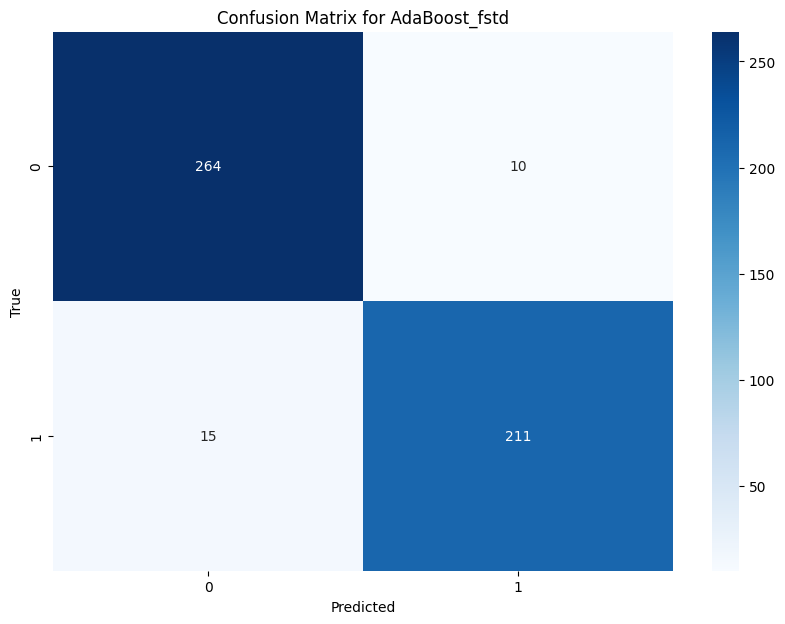

ROC Curve for AdaBoost_fstd


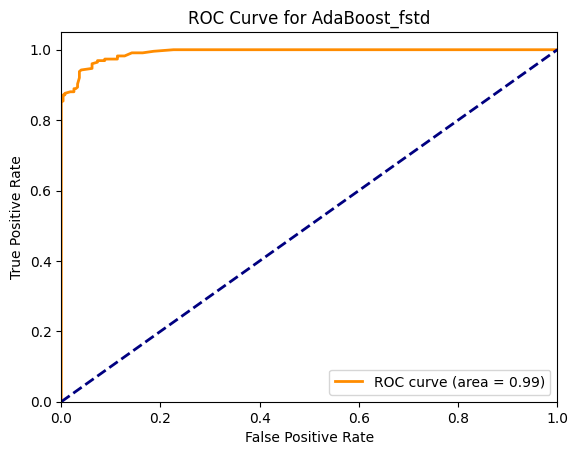

Confusion Matrix for AdaBoost_fstdr


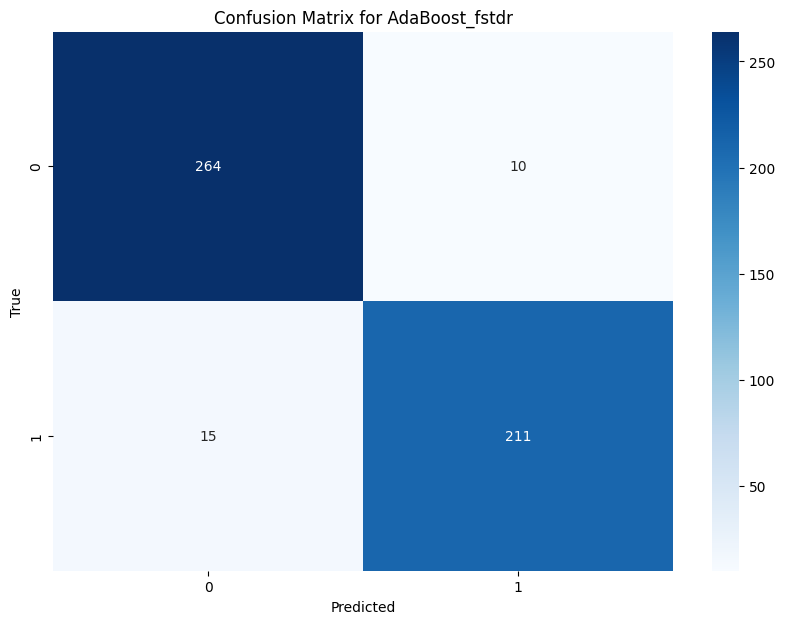

ROC Curve for AdaBoost_fstdr


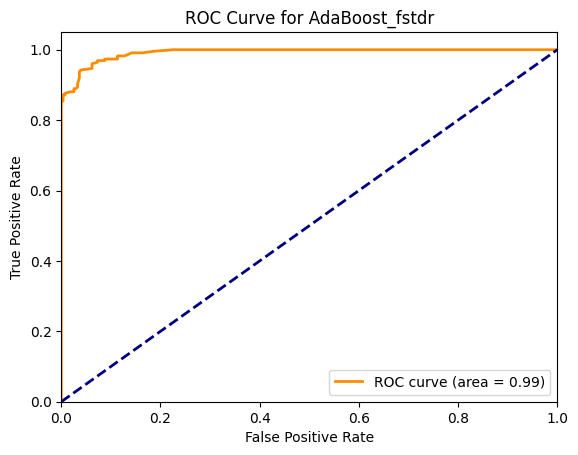

Confusion Matrix for AdaBoost_std


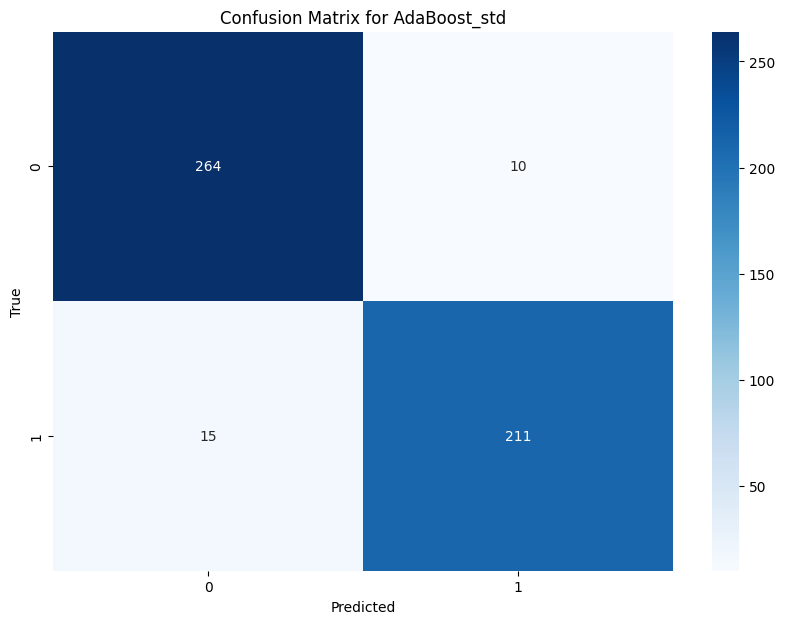

ROC Curve for AdaBoost_std


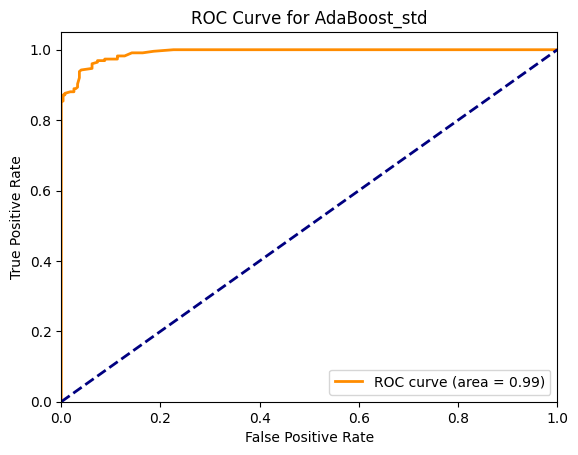

Confusion Matrix for AdaBoost_stdr


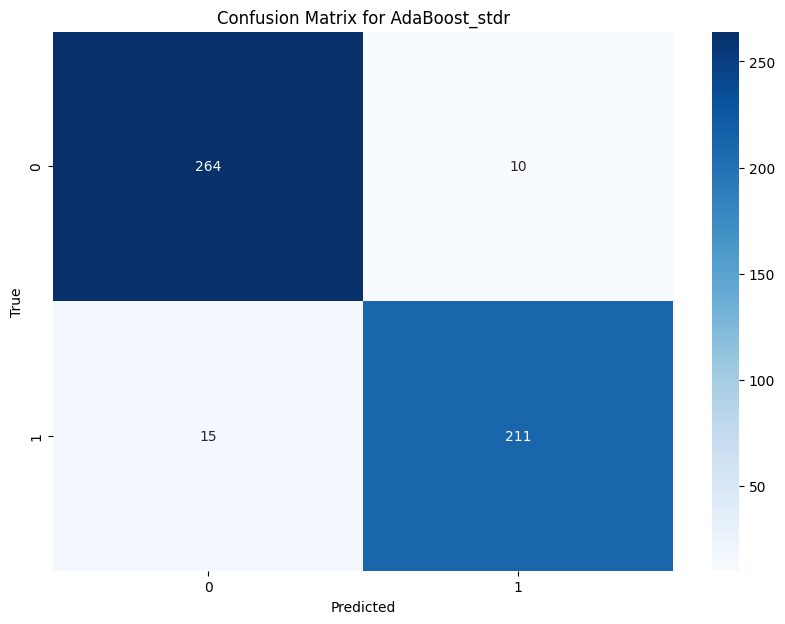

ROC Curve for AdaBoost_stdr


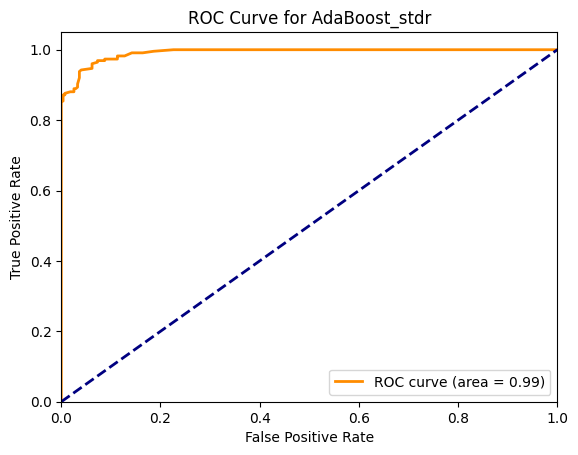

Confusion Matrix for DecisionTree_fstd


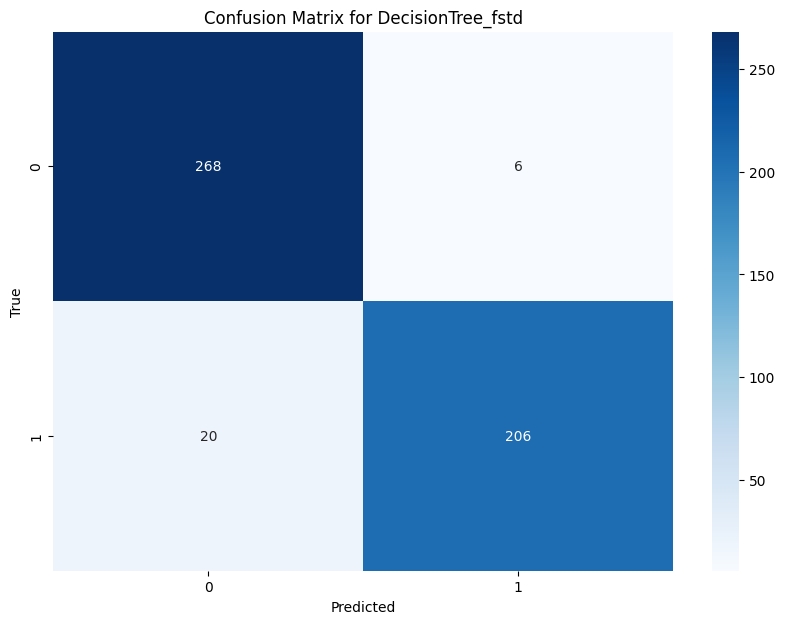

ROC Curve for DecisionTree_fstd


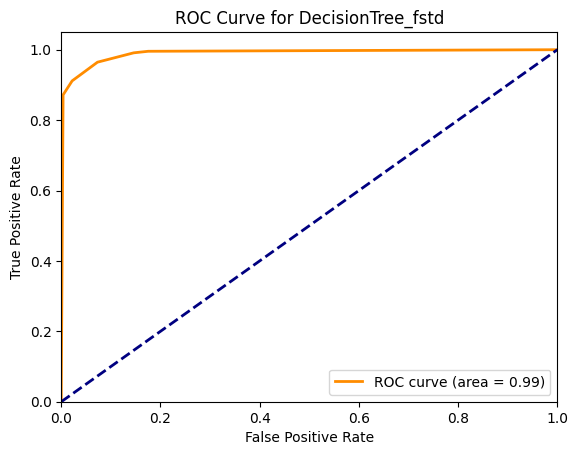

Confusion Matrix for DecisionTree_fstdr


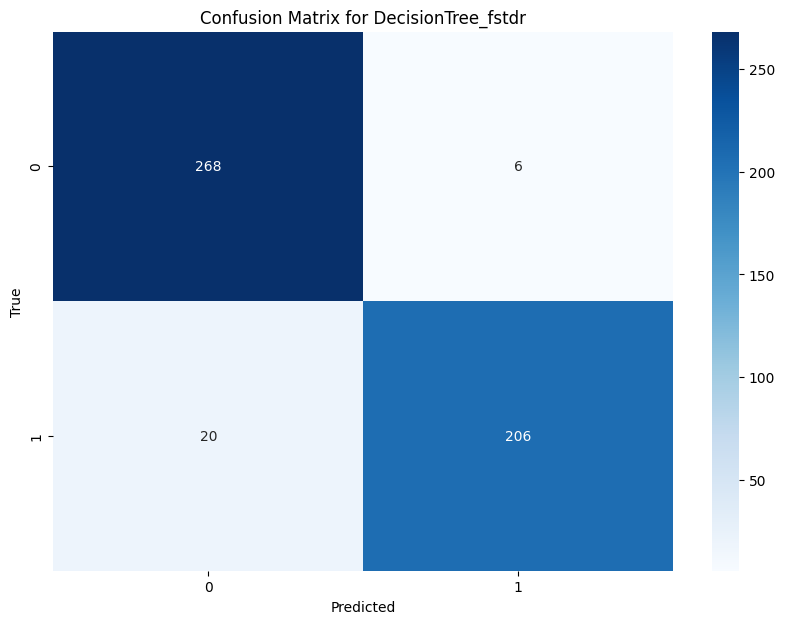

ROC Curve for DecisionTree_fstdr


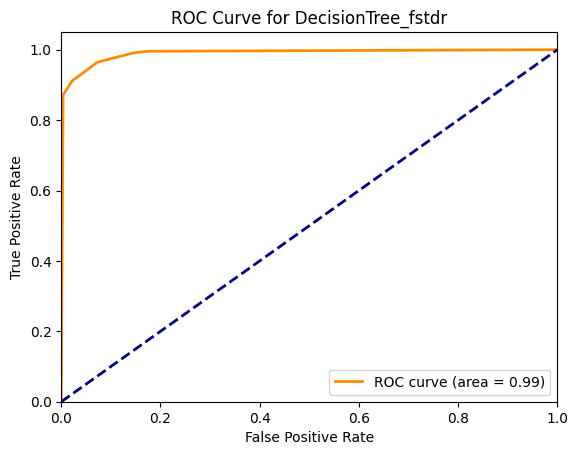

Confusion Matrix for DecisionTree_std


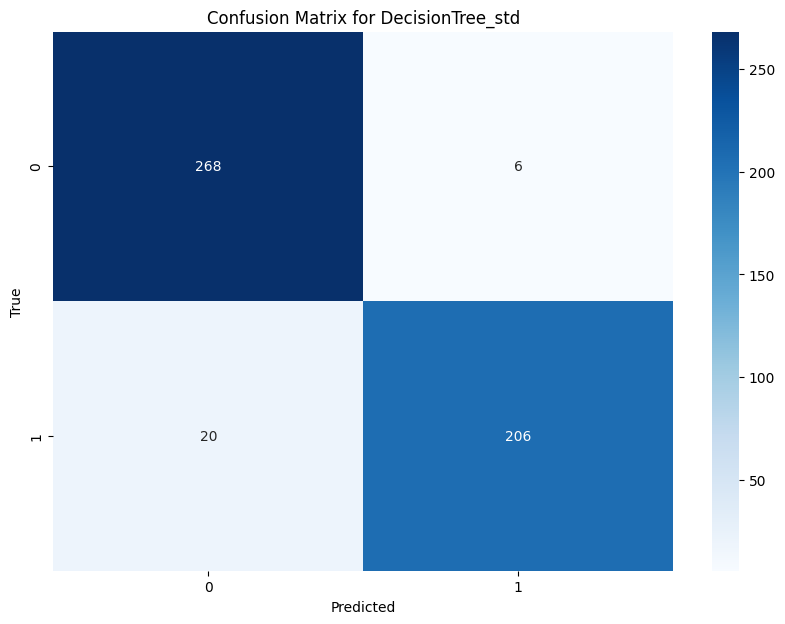

ROC Curve for DecisionTree_std


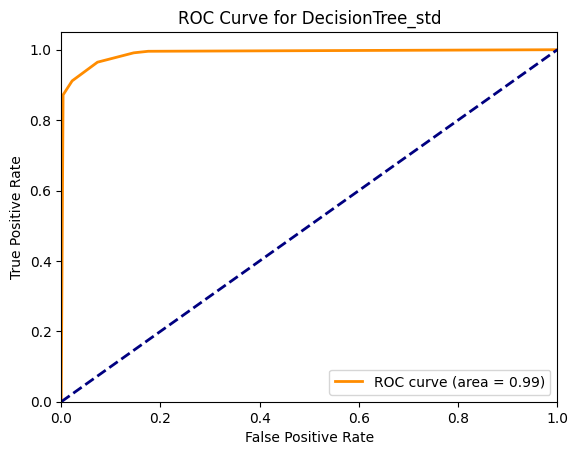

Confusion Matrix for DecisionTree_stdr


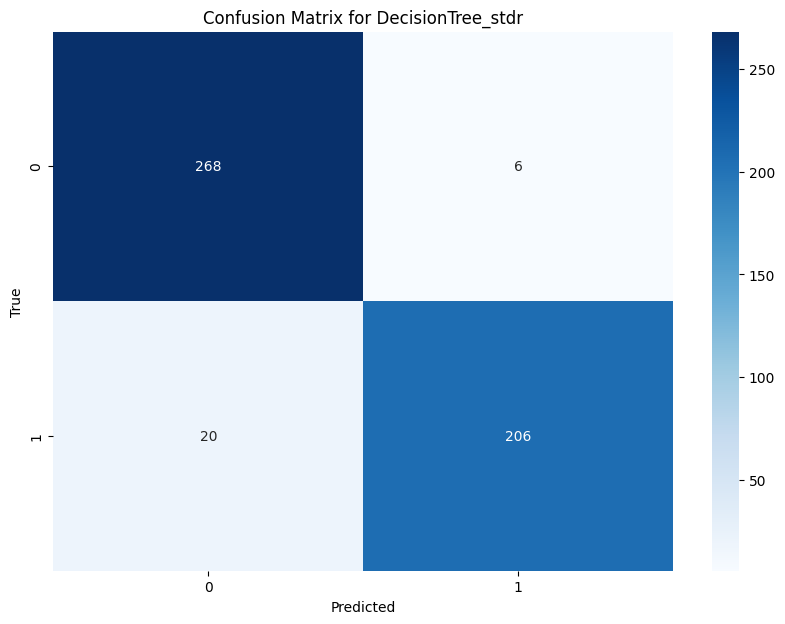

ROC Curve for DecisionTree_stdr


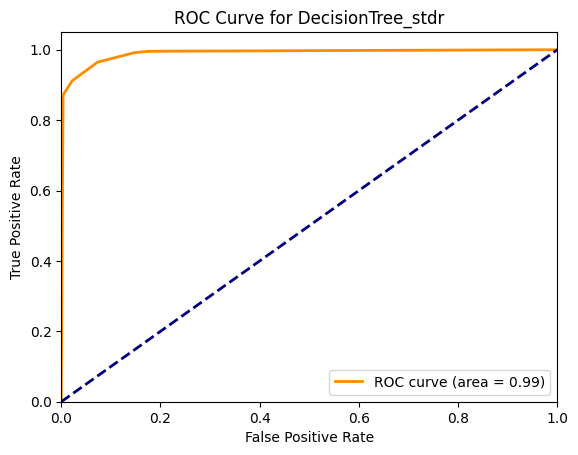

Confusion Matrix for GradientBoosting_fstd


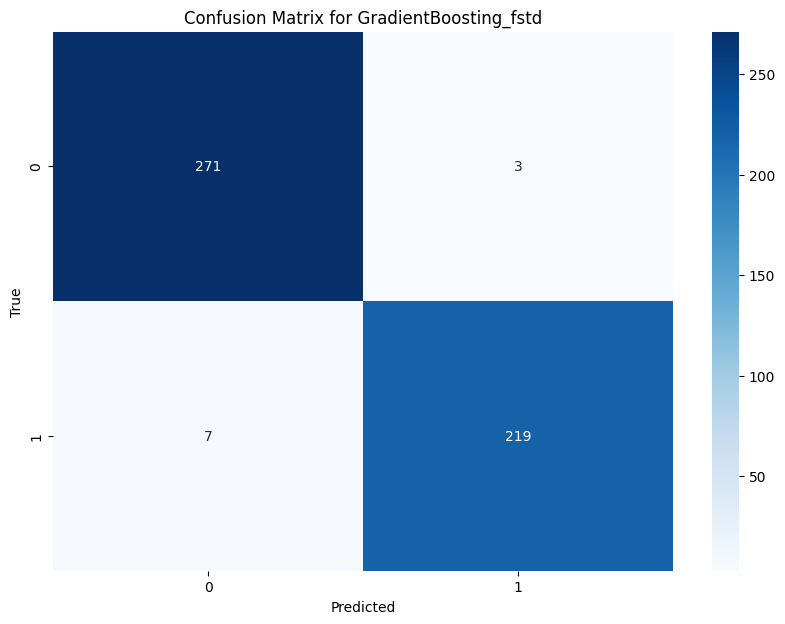

ROC Curve for GradientBoosting_fstd


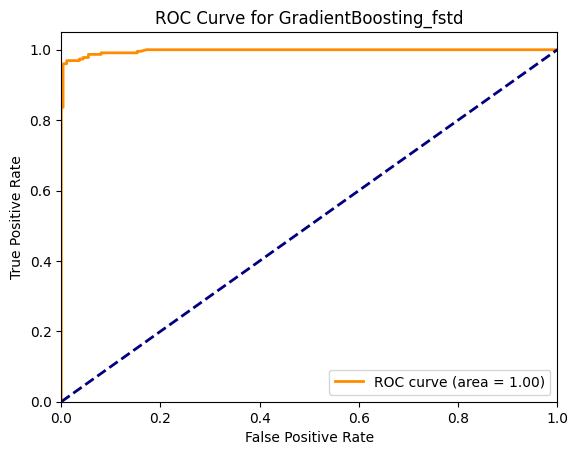

Confusion Matrix for GradientBoosting_fstdr


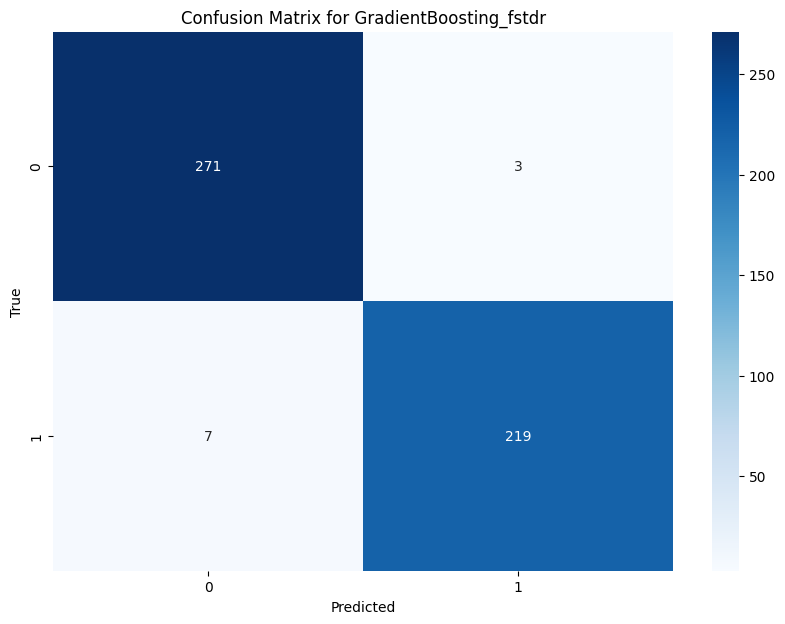

ROC Curve for GradientBoosting_fstdr


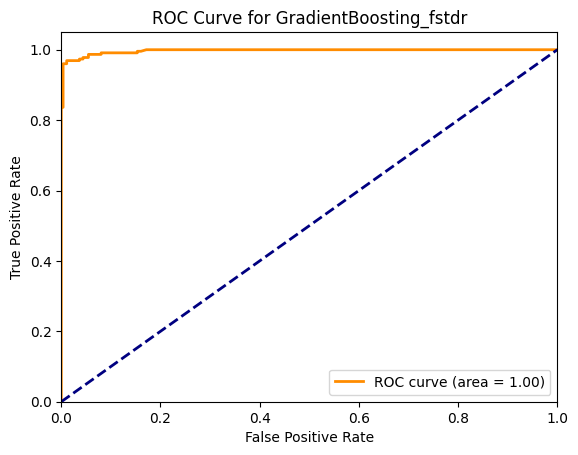

Confusion Matrix for GradientBoosting_std


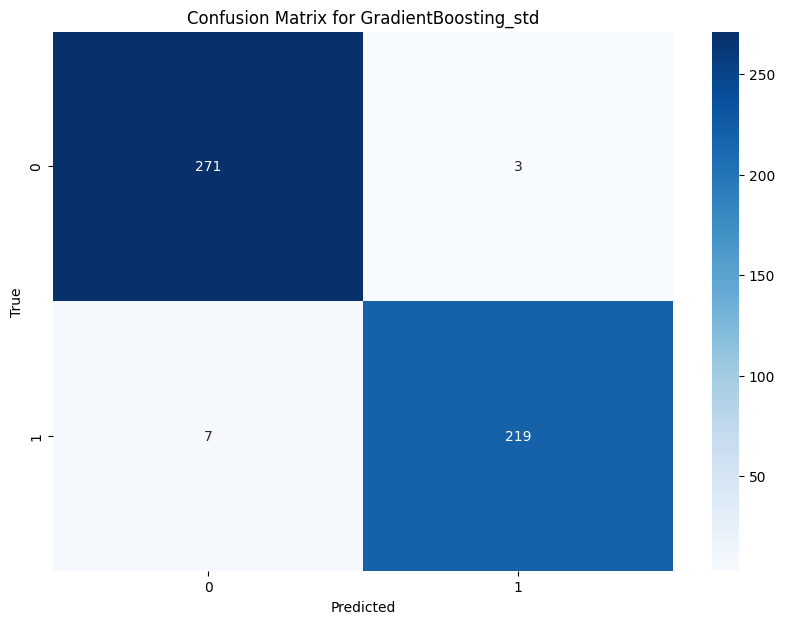

ROC Curve for GradientBoosting_std


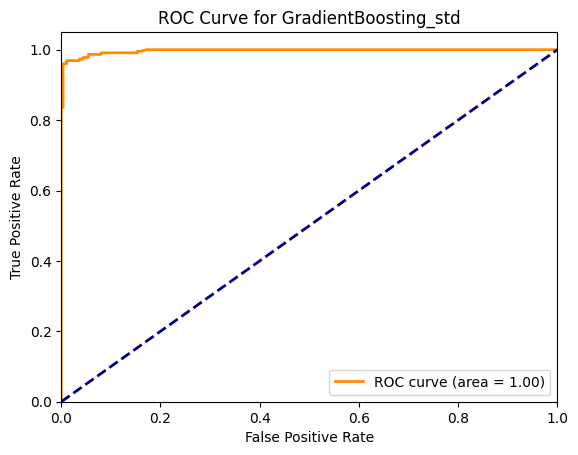

Confusion Matrix for GradientBoosting_stdr


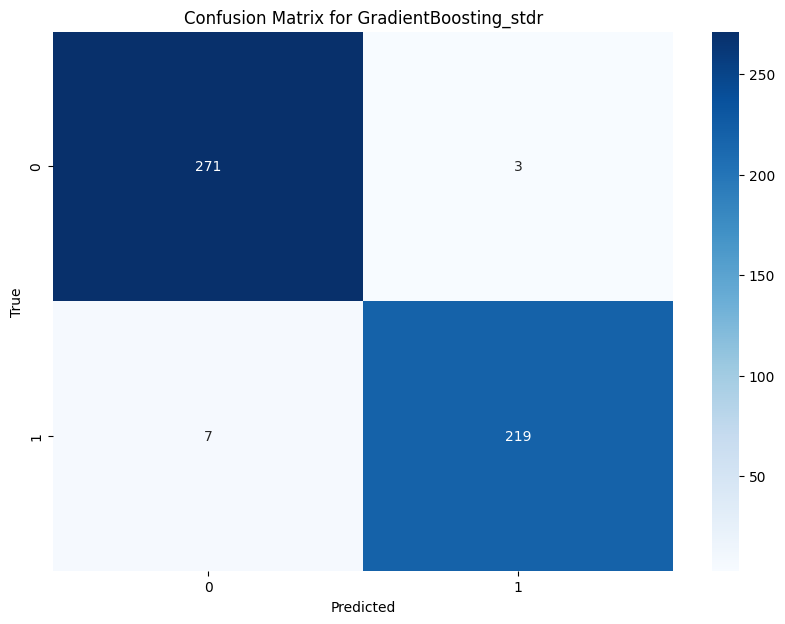

ROC Curve for GradientBoosting_stdr


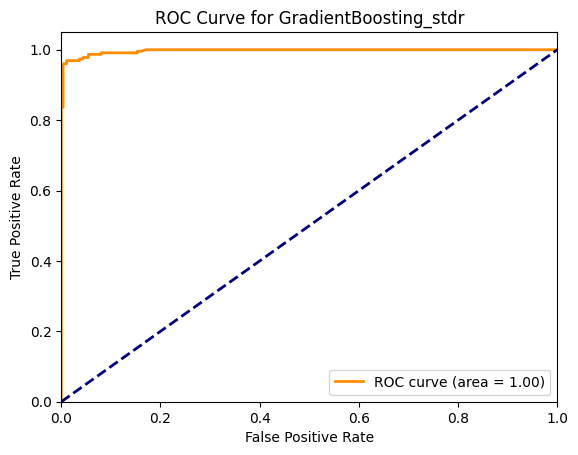

Confusion Matrix for LogisticRegression_fstd


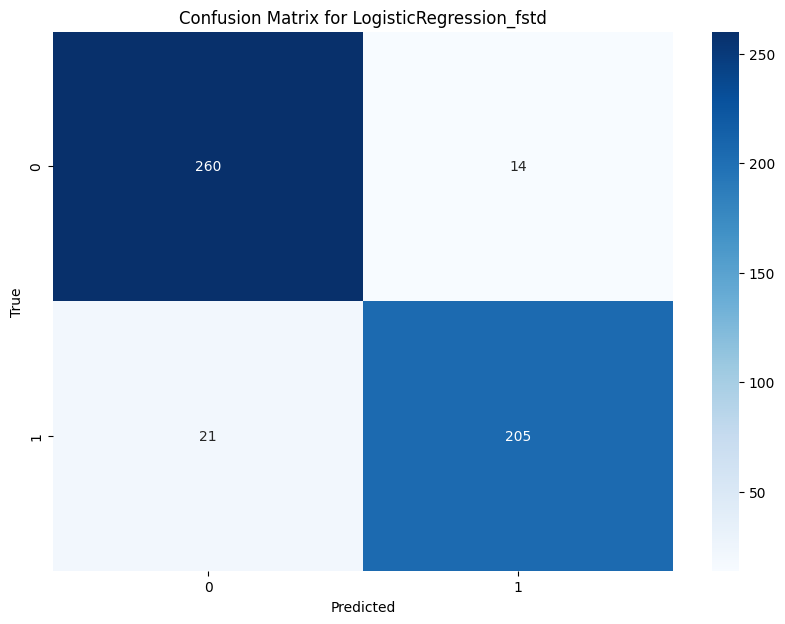

ROC Curve for LogisticRegression_fstd


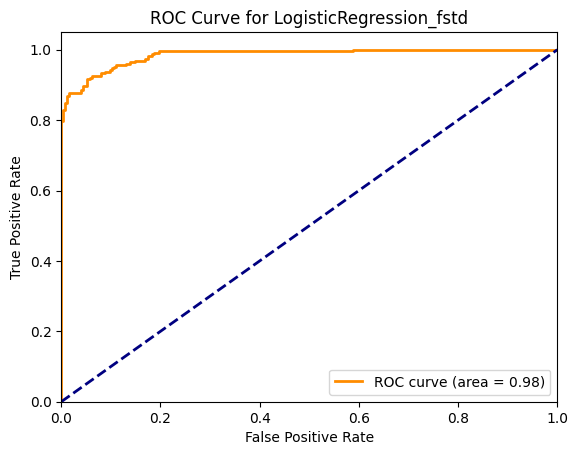

Confusion Matrix for LogisticRegression_fstdr


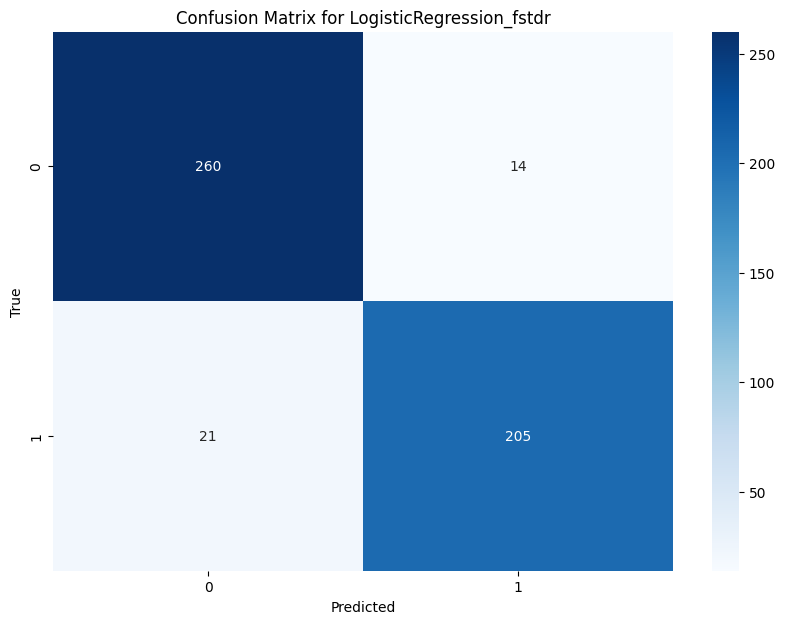

ROC Curve for LogisticRegression_fstdr


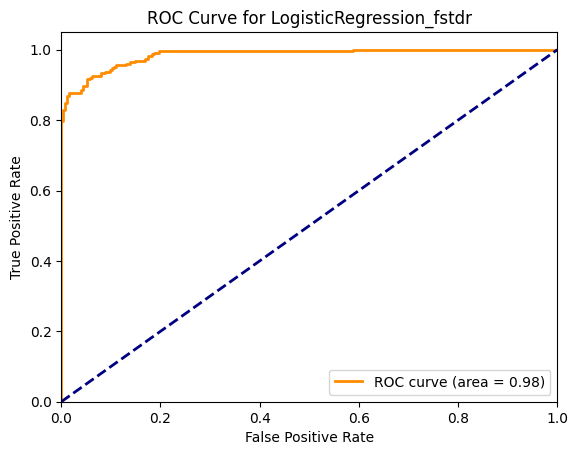

Confusion Matrix for LogisticRegression_std


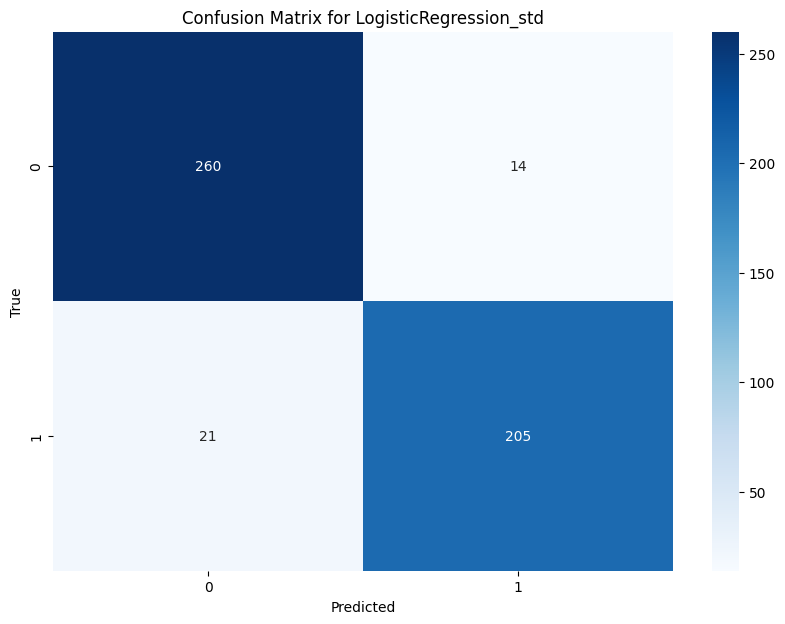

ROC Curve for LogisticRegression_std


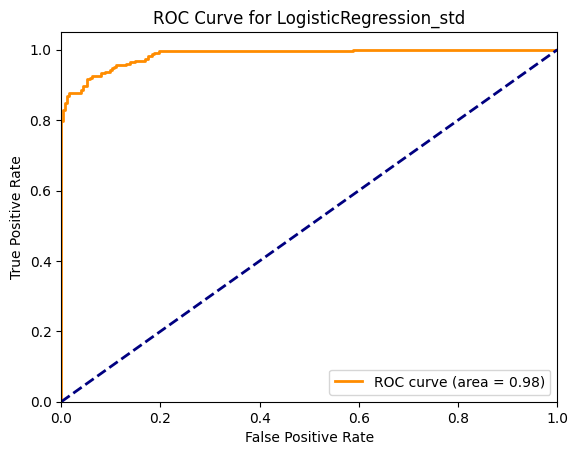

Confusion Matrix for LogisticRegression_stdr


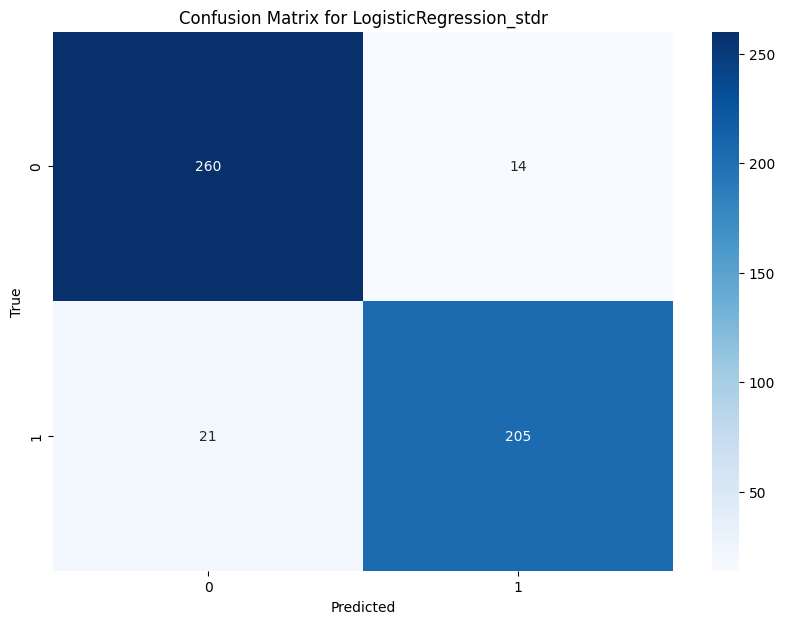

ROC Curve for LogisticRegression_stdr


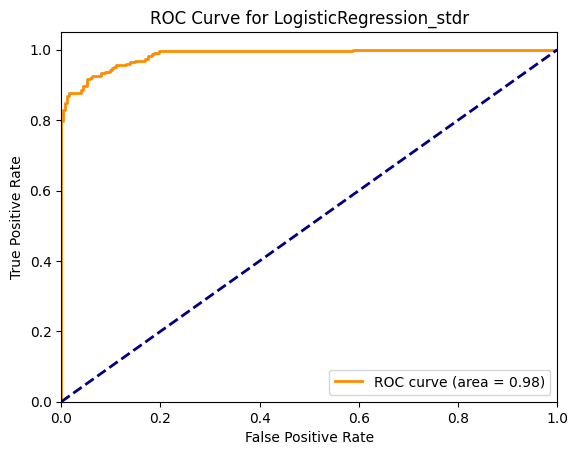

Confusion Matrix for RandomForest_fstd


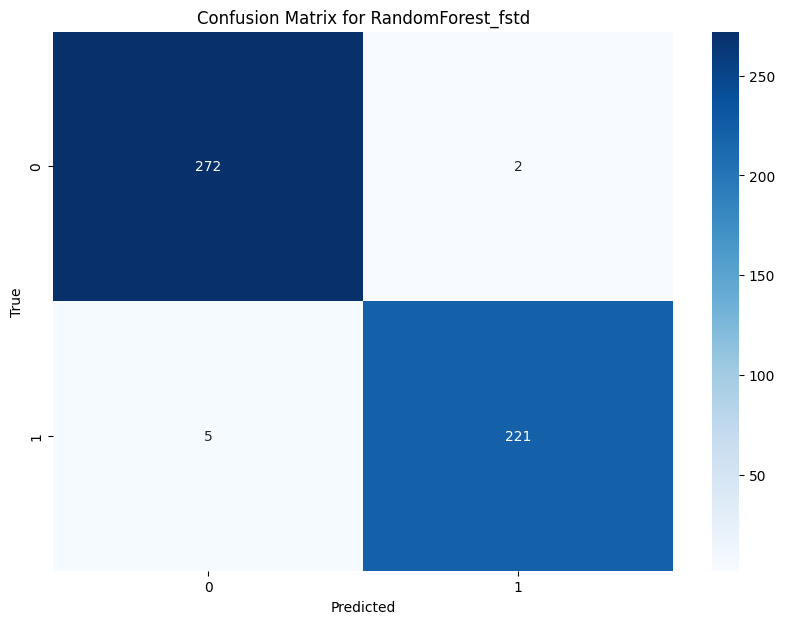

ROC Curve for RandomForest_fstd


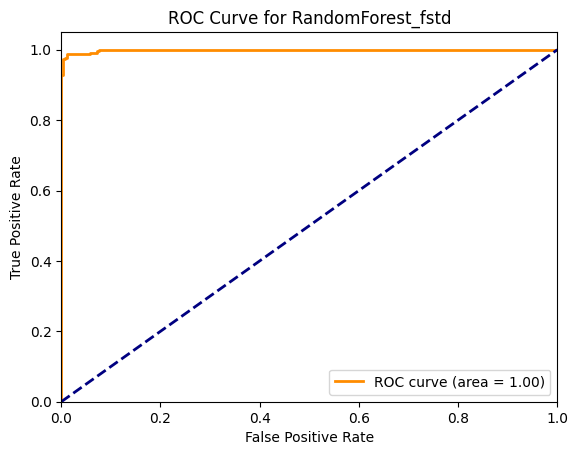

Confusion Matrix for RandomForest_fstdr


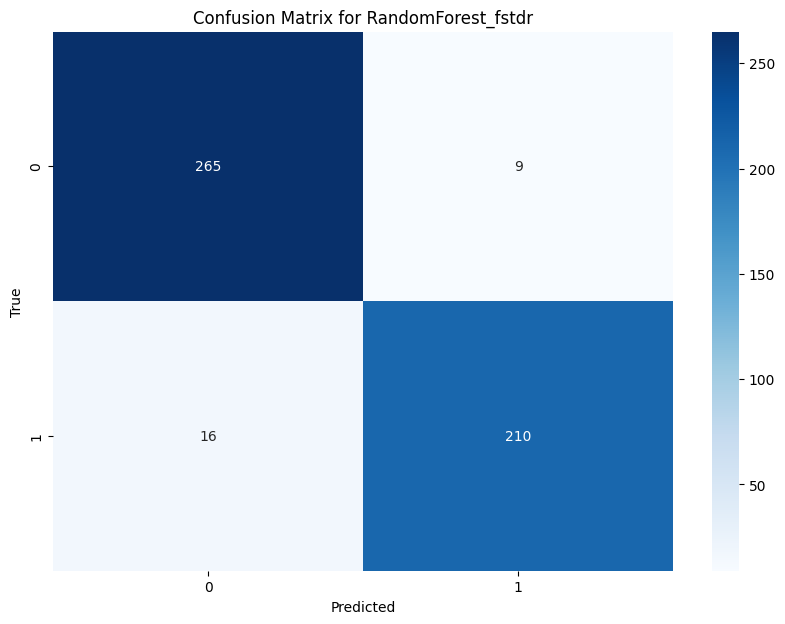

ROC Curve for RandomForest_fstdr


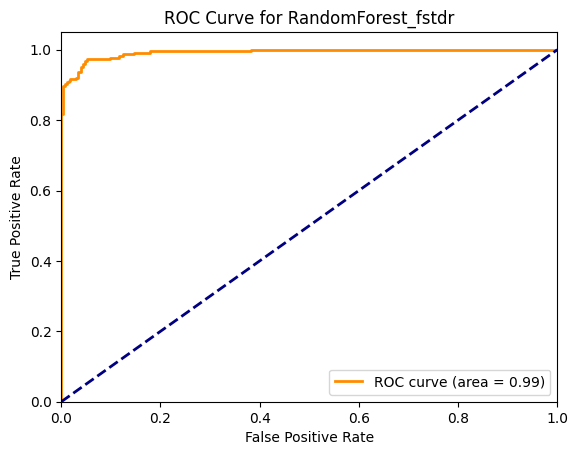

Confusion Matrix for RandomForest_std


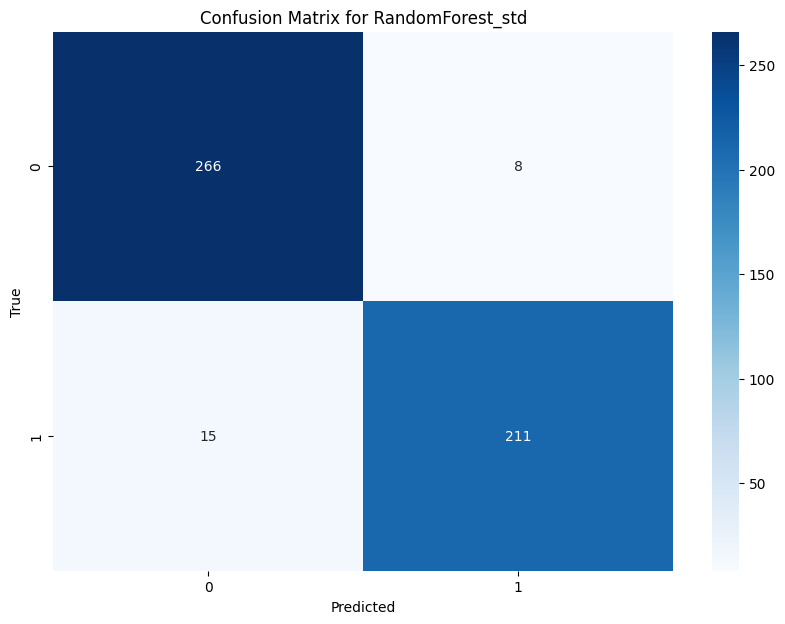

ROC Curve for RandomForest_std


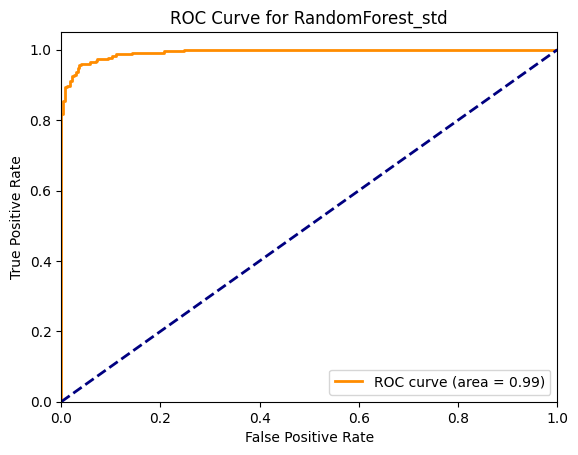

Confusion Matrix for RandomForest_stdr


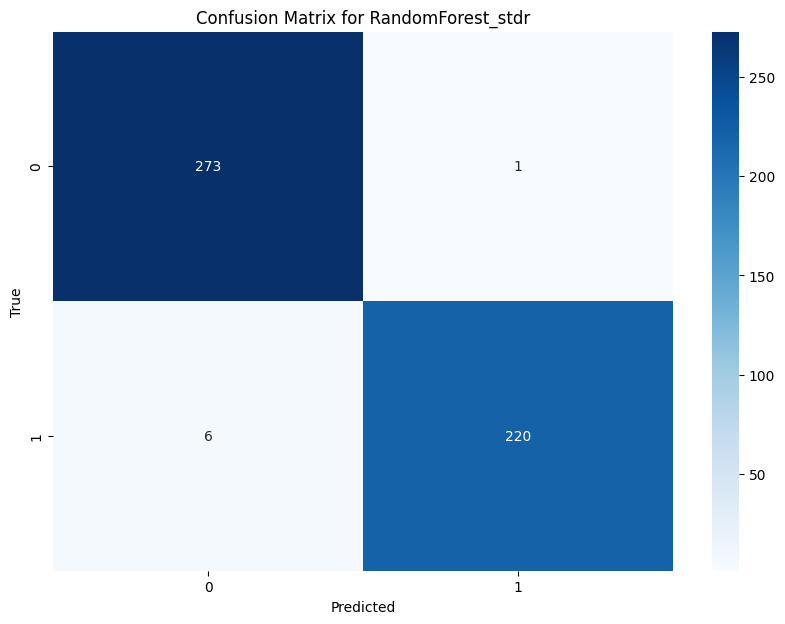

ROC Curve for RandomForest_stdr


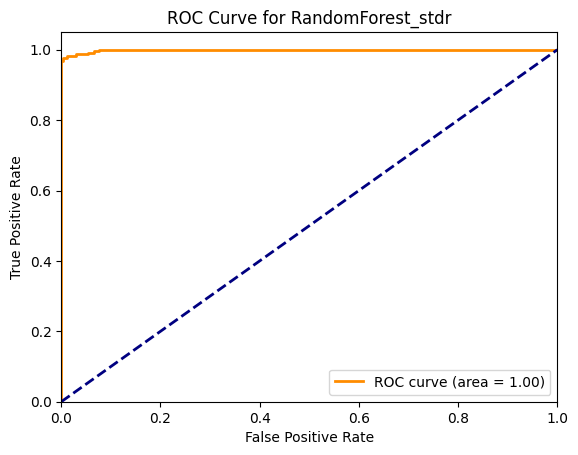

In [94]:
# Generar la matriz de confusión para cada modelo cargado
for model_name, model in loaded_models.items():
    if 'fstd' in model_name:
        X, y = X_fstd, y_fstd
    elif 'fstdr' in model_name:
        X, y = X_fstdr, y_fstdr
    elif 'std' in model_name:
        X, y = X_std, y_std
    elif 'stdr' in model_name:
        X, y = X_stdr, y_stdr
    else:
        continue
    
    print(f"Confusion Matrix for {model_name}")
    plot_confusion_matrix(model, X, y, title=f"Confusion Matrix for {model_name}")
    print(f"ROC Curve for {model_name}")
    plot_roc_curve(model, X, y, title=f"ROC Curve for {model_name}")

Confusion Matrix for model_1_fstdr


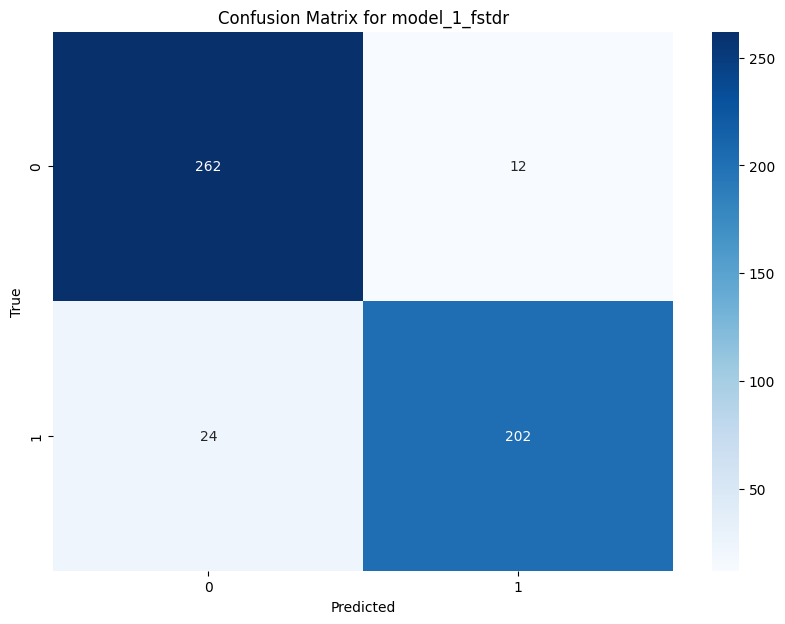

ROC Curve for model_1_fstdr


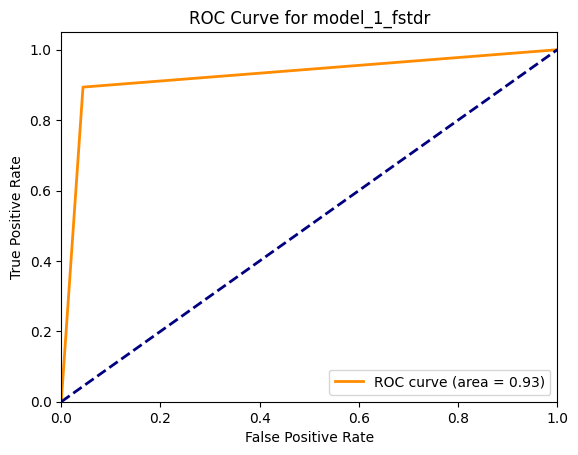

Confusion Matrix for model_1_stdr


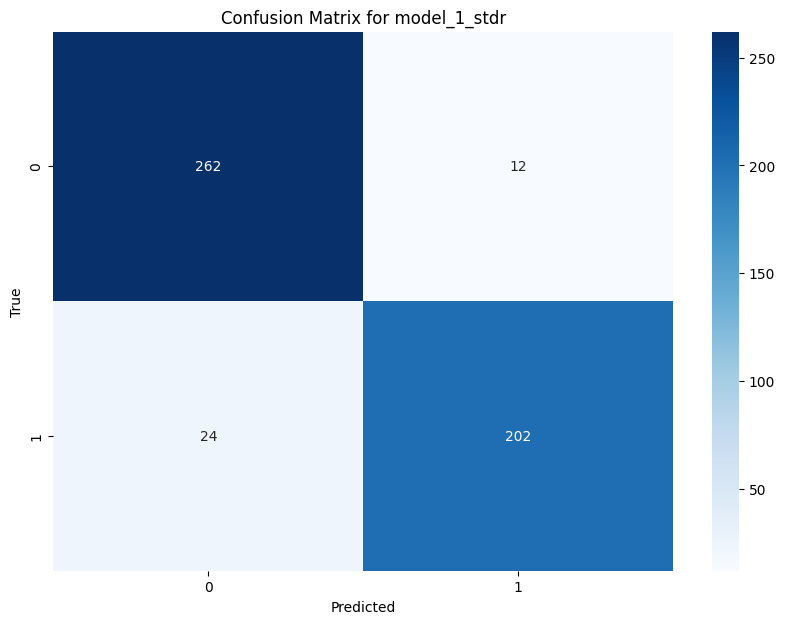

ROC Curve for model_1_stdr


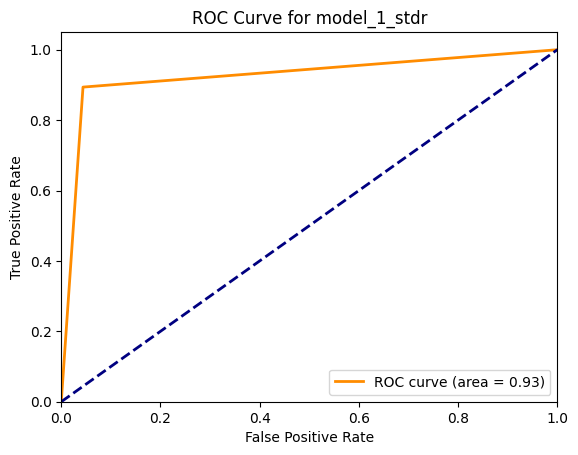

Confusion Matrix for model_1_fstd


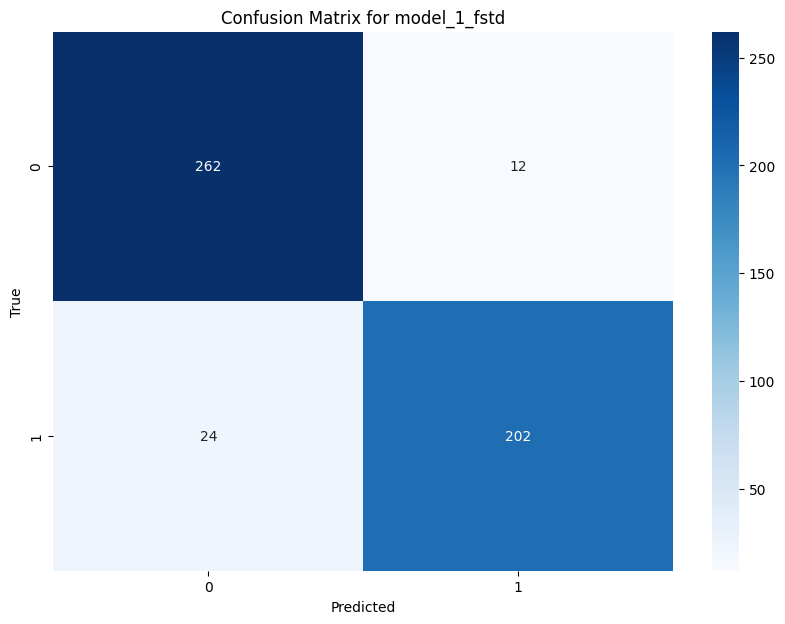

ROC Curve for model_1_fstd


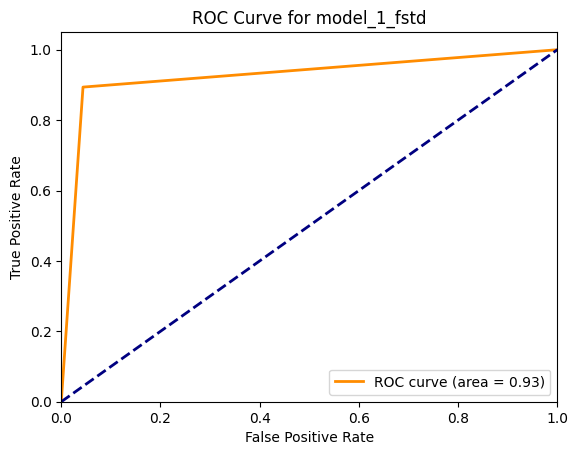

Confusion Matrix for model_1_std


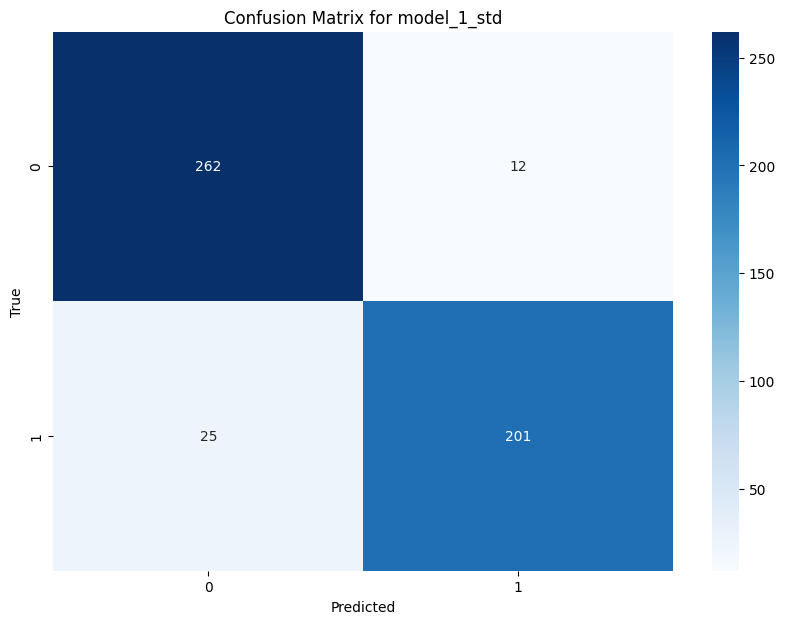

ROC Curve for model_1_std


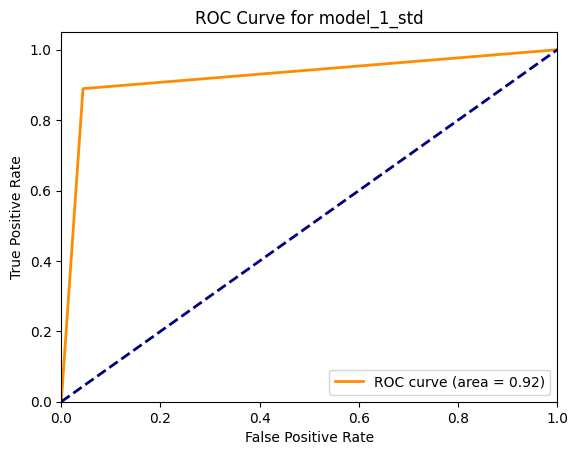

Confusion Matrix for model_2_fstdr


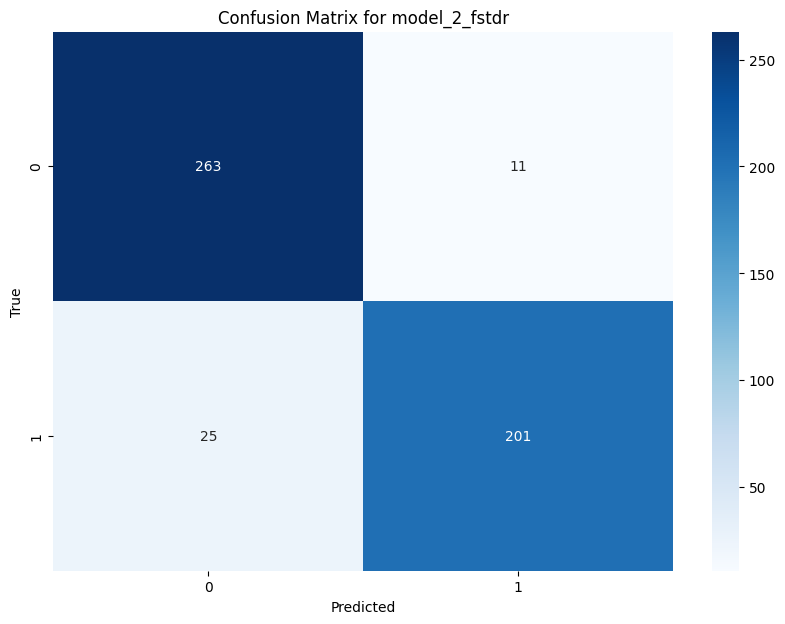

ROC Curve for model_2_fstdr


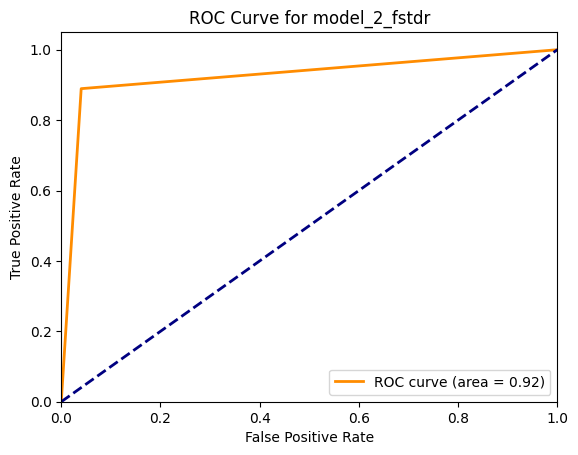

Confusion Matrix for model_2_stdr


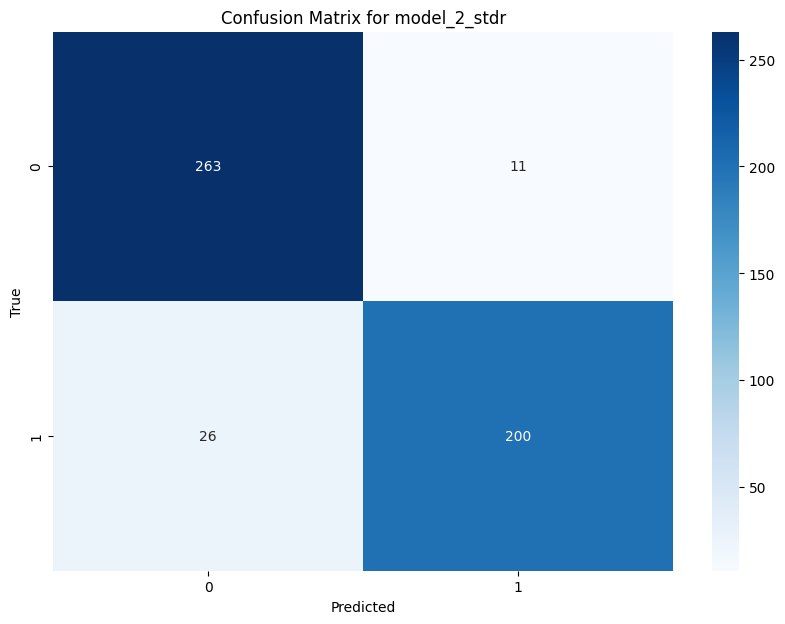

ROC Curve for model_2_stdr


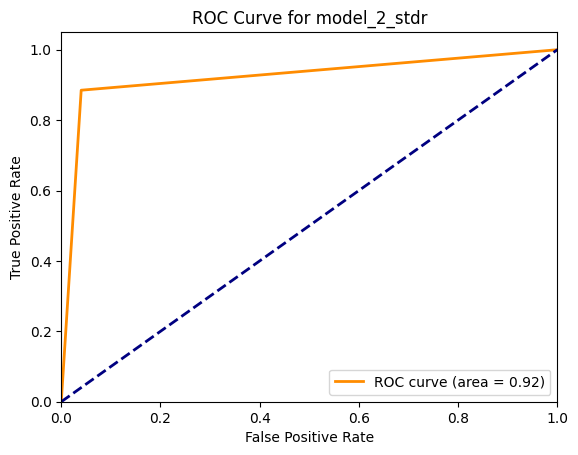

Confusion Matrix for model_2_fstd


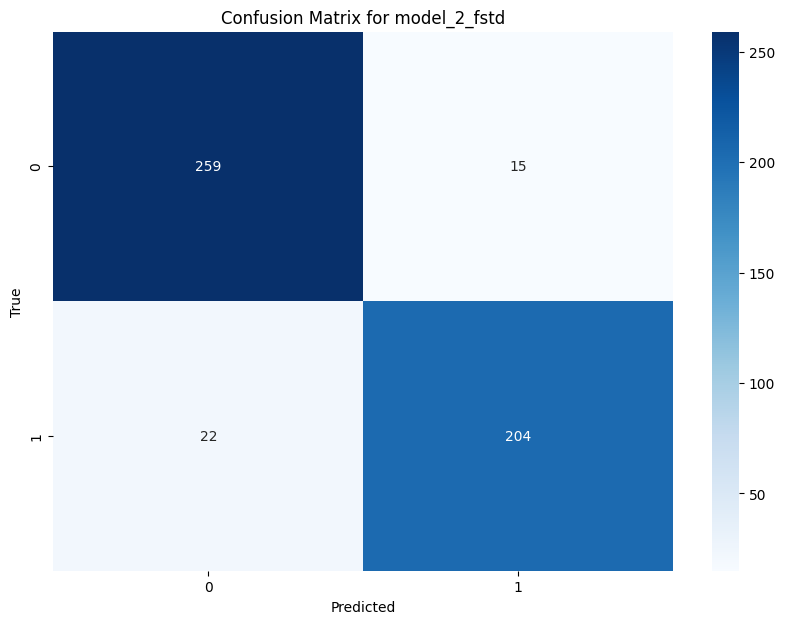

ROC Curve for model_2_fstd


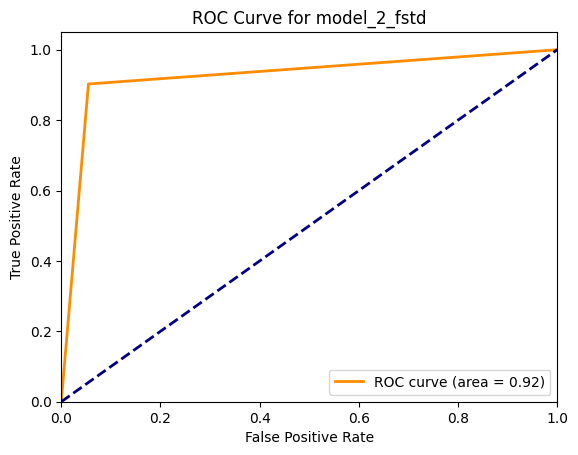

Confusion Matrix for model_2_std


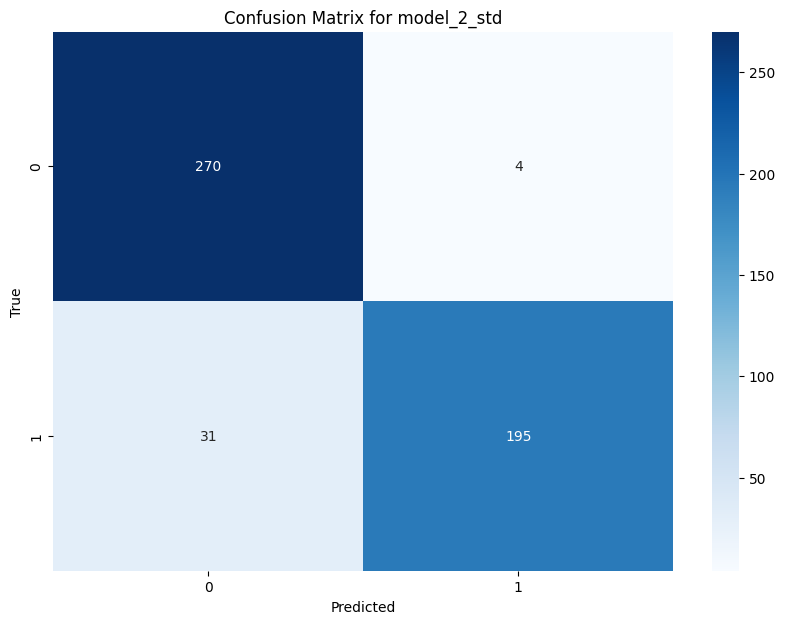

ROC Curve for model_2_std


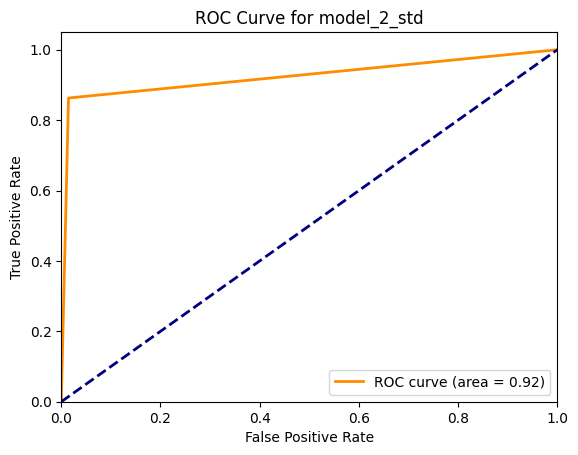

In [91]:
models = {
    "model_1_fstdr": model_1_fstdr,
    "model_1_stdr": model_1_stdr,
    "model_1_fstd": model_1_fstd,
    "model_1_std": model_1_std,
    "model_2_fstdr": model_2_fstdr,
    "model_2_stdr": model_2_stdr,
    "model_2_fstd": model_2_fstd,
    "model_2_std": model_2_std
}
def plot_confusion_matrix_pytorch(model, X, y, batch_size=500, title="Confusion Matrix"):
    """
    Esta función recibe un modelo de PyTorch, un dataset y las etiquetas verdaderas,
    y genera una matriz de confusión.
    
    Parameters:
    model: El modelo de PyTorch entrenado.
    X: Las características del dataset.
    y: Las etiquetas verdaderas del dataset.
    batch_size: Tamaño del batch para la predicción.
    title: Título de la matriz de confusión.
    """
    device = next(model.parameters()).device
    model.eval()
    X_tensor = torch.Tensor(X).to(device).float()
    y_tensor = torch.tensor(y, dtype=torch.uint8).to(device)
    loader = data.DataLoader(data.TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            preds = outputs.cpu().numpy()
            preds = (preds > 0).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def plot_roc_curve_pytorch(model, X, y, batch_size=500, title="ROC Curve"):
    """
    Esta función recibe un modelo de PyTorch, un dataset y las etiquetas verdaderas,
    y genera una curva ROC.
    
    Parameters:
    model: El modelo de PyTorch entrenado.
    X: Las características del dataset.
    y: Las etiquetas verdaderas del dataset.
    batch_size: Tamaño del batch para la predicción.
    title: Título de la curva ROC.
    """
    device = next(model.parameters()).device
    model.eval()
    X_tensor = torch.Tensor(X).to(device).float()
    y_tensor = torch.tensor(y, dtype=torch.uint8).to(device)
    loader = data.DataLoader(data.TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=False)
    
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            preds = outputs.cpu().numpy()
            preds = (preds > 0).astype(int)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


for model_name, model in models.items():
    if 'fstd' in model_name:
        X, y = X_fstd, y_fstd
    elif 'fstdr' in model_name:
        X, y = X_fstdr, y_fstdr
    elif 'std' in model_name:
        X, y = X_std, y_std
    elif 'stdr' in model_name:
        X, y = X_stdr, y_stdr
    else:
        continue
    
    print(f"Confusion Matrix for {model_name}")
    plot_confusion_matrix_pytorch(model, X, y, title=f"Confusion Matrix for {model_name}")
    print(f"ROC Curve for {model_name}")
    plot_roc_curve_pytorch(model, X, y, title=f"ROC Curve for {model_name}")

# Training Ensabled Staking

In [2]:
from models.meta_classifier import MetaClassifier
from models.custom_Resnet34 import ResNet34
from models.custom_Resnet50 import ResNet50
from models.custom_VGG16 import PyTorchVGG16Logits
from models.inception import inception_v3
from read_imgs import Preprocess

In [ ]:
vgg16 = PyTorchVGG16Logits()
resnet = ResNet34()
resnet50 = ResNet50()
inception = inception_v3(num_classes=1)

"""
funcion que guarda el modelo, utilizada principalmente para earling stopping
"""
def save_model(model, path):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, path)

"""
funcion que carga el modelo. Utilizada para cojer el mejor modelo del entrenamiento
"""
def load_model(PATH, model):
    import io
    with open(PATH, 'rb') as f:
        buffer = io.BytesIO(f.read())
    checkpoint = torch.load(buffer, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

meta_fstdr = MetaClassifier([load_model(f"models_classification/resnet_fstdr.pth",resnet), 
                            load_model(f"models_classification/resnet50_fstdr.pth",resnet50), 
                            load_model(f"models_classification/vgg16_fstdr.pth",vgg16), 
                            load_model(f"models_classification/inception_v3_fstdr.pth",inception)], num_classes=1)

# meta_fstd = MetaClassifier([load_model(f"models_classification/resnet_fstd.pth",resnet), 
#                             load_model(f"models_classification/resnet50_fstd.pth",resnet50), 
#                             load_model(f"models_classification/vgg16_fstd.pth",vgg16), 
#                             load_model(f"models_classification/inception_v3_fstd.pth",inception)], num_classes=1)

# meta_stdr = MetaClassifier([load_model(f"models_classification/resnet_stdr.pth",resnet), 
#                             load_model(f"models_classification/resnet50_stdr.pth",resnet50), 
#                             load_model(f"models_classification/vgg16_stdr.pth",vgg16), 
#                             load_model(f"models_classification/inception_v3_stdr.pth",inception)], num_classes=1)

# meta_std = MetaClassifier([load_model(f"models_classification/resnet_std.pth",resnet), 
#                             load_model(f"models_classification/resnet50_std.pth",resnet50), 
#                             load_model(f"models_classification/vgg16_std.pth",vgg16), 
#                             load_model(f"models_classification/inception_v3_std.pth",inception)], num_classes=1)

NameError: name 'train' is not defined

In [4]:

path = "./"

images_dir = os.path.join(path, "preprosImg")
"""Check if the images directory exists
"""
if not os.path.exists(images_dir): raise FileNotFoundError(f"The directory {images_dir} does not exist.")
"""List and sort files in the images directory
"""
files = sorted([
    f for f in os.listdir(images_dir) 
    if os.path.isfile(os.path.join(images_dir, f))
])

"""Output the sorted list of image files
"""
excel = pd.read_excel(path+"/clases.xlsx")
prepros = Preprocess()
_,_,_,_, X_fstdr,Y_fstdr,_,_= prepros(images_dir, files, excel)


./preprosImg
3000


In [5]:
# meta_fstd = load_model(f"meta_models/meta_fstd.pth",meta_fstd)
# meta_stdr = load_model(f"meta_models/meta_stdr.pth",meta_stdr)
meta_fstdr = load_model(f"meta_models/meta_fstdr.pth",meta_fstdr)
# meta_std = load_model(f"meta_models/meta_std.pth",meta_std)

In [9]:
import datetime

def delta_time(model, img):
    ti  = datetime.datetime.now()
    print(ti)
    model.to("cuda")
    model.eval()
    _ = model(torch.Tensor(img).to("cuda").float())
    model.to("cpu")
    tf = datetime.datetime.now()
    print(tf)
    print(tf-ti)
    return tf-ti

# delta_time(meta_fstd, X_fstd[0])
delta_time(meta_fstdr, X_fstdr[0:1])
# delta_time(meta_std, X_fstd[0])
# delta_time(meta_stdr, X_fstd[0])

2025-03-27 17:25:37.987229
2025-03-27 17:25:40.105802
0:00:02.118573


datetime.timedelta(seconds=2, microseconds=118573)